# **Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import shutil
import os
import shutil
from tqdm import tqdm

import tensorflow as tf
import keras
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers, Model
from keras.models import Sequential, Model
from keras.layers import *

In [ ]:
Covid_Classes = ['covid', 'normal', 'virus']

In [ ]:
def Plot_Classes(BASE_URL, Rows=2, Columns=5):
  
  """
  Plot a Random Image of Each Class in Train/Test Folder.
  """

  plt.figure(figsize = (25, 8))

  image_count = 1

  for directory in os.listdir(BASE_URL):
      
      if directory[0] != '.':

          Max_Random = len(os.listdir(os.path.join(BASE_URL,directory)))

          Random_Number = np.random.randint(0, Max_Random)

          for i, file in enumerate(os.listdir(BASE_URL + directory)):
              
              if i == Random_Number:

                  fig = plt.subplot(Rows, Columns, image_count)
                  image_count += 1

                  image = plt.imread(BASE_URL + directory + '/' + file)
                  plt.imshow(image)

                  plt.title(directory)

                  break

In [ ]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.figure(figsize=(15,5))
  plt.style.use('ggplot')

  #plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, 'bo-' , label = "TrainL oss")
  plt.plot(epochs, val_loss, 'o-' , color='orange', label = "Val Loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, 'bo-' , label = "Train Acc")
  plt.plot(epochs, val_accuracy, 'o-' , color='orange' , label = "Val Acc")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

  plt.style.use('default')
  
  #plt.tight_layout()

# **Covid Data Exploration**

In [ ]:
TrainData_Dir = '/kaggle/input/shai-level-2-training-2023/train/'

### **Exploring CSV Files**

In [ ]:
df = pd.read_csv('/kaggle/input/shai-level-2-training-2023/train.csv')
df.head(5)

Image   Label
0  597631776.jpeg  normal
1   35266064.jpeg   virus
2  467414642.jpeg  normal
3   35667640.jpeg  normal
4  618841263.jpeg  normal

In [ ]:
df.Label.count()

1196

- **We Have Only 1196 to Train the Model and Test it's Performence on.**

In [ ]:
px.histogram(df, y="Label", color="Label", title="Classes Distribution").update_yaxes(categoryorder='total ascending')

- **The Classes are not very balanced, with Covid Class Being Less Present than others.**

### **Visualizing Classes**

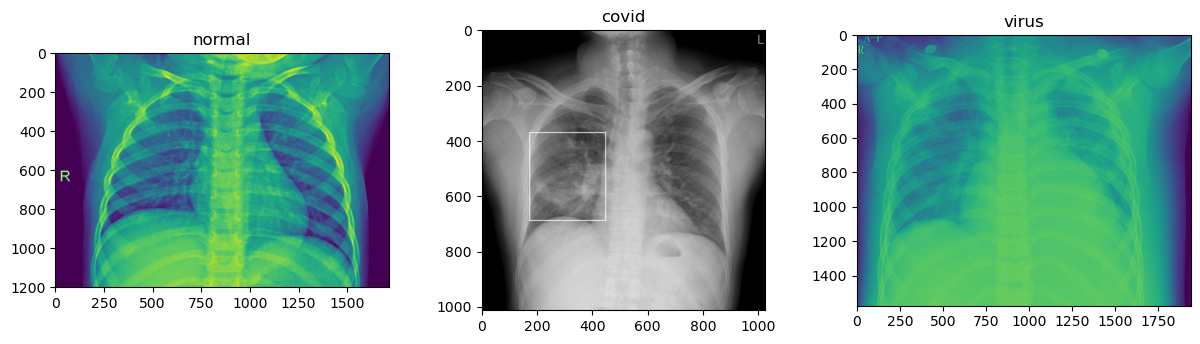

In [ ]:
Plot_Classes(TrainData_Dir) 

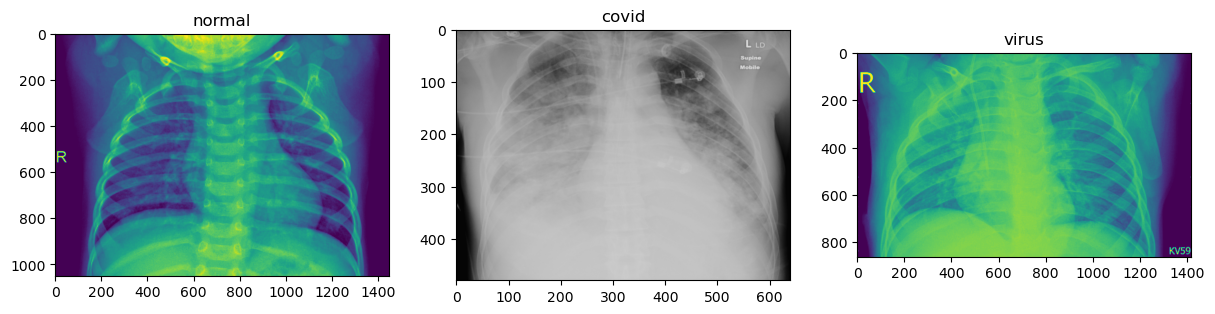

In [ ]:
Plot_Classes(TrainData_Dir) 

(480, 640, 3)


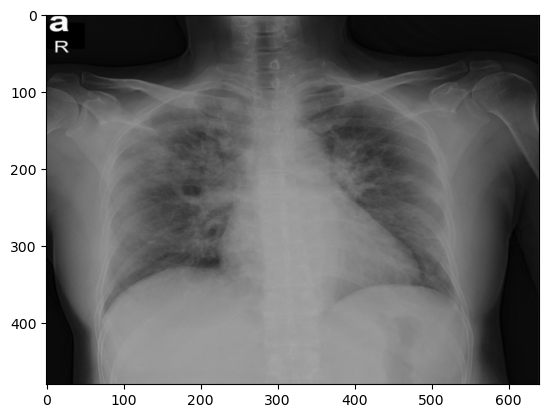

In [ ]:
covidImg = plt.imread('/kaggle/input/shai-level-2-training-2023/train/covid/100126173.png')
print(covidImg.shape)
plt.imshow(covidImg)

- **Notice that the Covid Class Images are Represnted as RGB Array of Images and it's Float Type (normalizaed).**

In [ ]:
covidImg[0]

array([[0.05098039, 0.05098039, 0.05098039],
       [0.05098039, 0.05098039, 0.05098039],
       [0.04705882, 0.04705882, 0.04705882],
       ...,
       [0.04313726, 0.04313726, 0.04313726],
       [0.03529412, 0.03529412, 0.03529412],
       [0.10196079, 0.10196079, 0.10196079]], dtype=float32)

(1228, 1480)


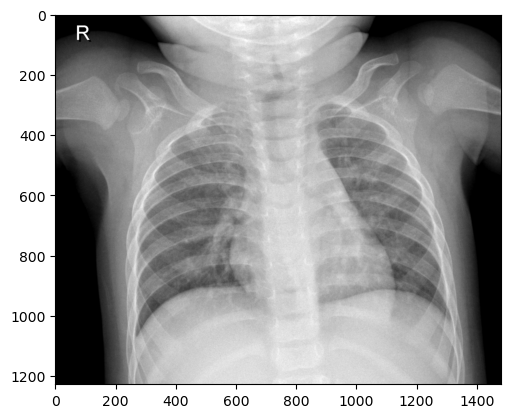

In [ ]:
normalImg = plt.imread('/kaggle/input/shai-level-2-training-2023/train/normal/100399932.jpeg')
print(normalImg.shape)
plt.imshow(normalImg, cmap='gray')

In [ ]:
normalImg[normalImg!=0]

array([ 1,  6, 13, ..., 13,  5,  1], dtype=uint8)

(720, 1240)


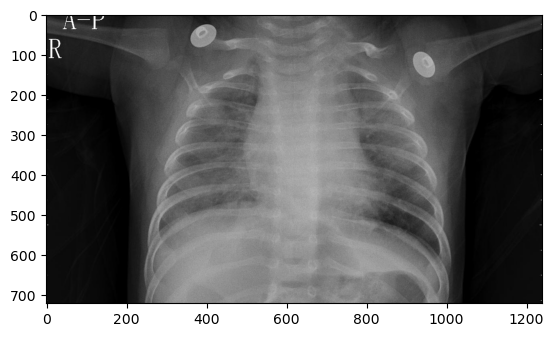

In [ ]:
virusImg = plt.imread('/kaggle/input/shai-level-2-training-2023/train/virus/100770198.jpeg')
print(virusImg.shape)
plt.imshow(virusImg, cmap='gray')

In [ ]:
virusImg[virusImg!=0]

array([33, 32, 31, ...,  9, 13, 15], dtype=uint8)

- **Unlike the other two Classes being real gray scaled images with int Types(not normalized).**

# **Fixing CSV File**

- **Let's make the csv have the full path to images to able to flow it to Data Generators right from the csv file.**

In [ ]:
df.head()

Image   Label
0  597631776.jpeg  normal
1   35266064.jpeg   virus
2  467414642.jpeg  normal
3   35667640.jpeg  normal
4  618841263.jpeg  normal

In [ ]:
for index, row in df.iterrows():

  path_to_img = TrainData_Dir + row['Label'] + '/' + row['Image'] 

  row['Image'] = path_to_img

In [ ]:
df.head()

Image   Label
0  /kaggle/input/shai-level-2-training-2023/train...  normal
1  /kaggle/input/shai-level-2-training-2023/train...   virus
2  /kaggle/input/shai-level-2-training-2023/train...  normal
3  /kaggle/input/shai-level-2-training-2023/train...  normal
4  /kaggle/input/shai-level-2-training-2023/train...  normal

In [ ]:
df.Image[0]

'/kaggle/input/shai-level-2-training-2023/train/normal/597631776.jpeg'

# **Splitting Test-Val Sets**

- **Now Let's Split the Data to Test-Val Splits that have the Same Class Distribution as Original Data.**

In [ ]:
X = df.drop(columns="Label")
y = df["Label"]

# Validation Split
X_train, X_val, y_train, y_val = train_test_split( X , y , stratify = y, test_size=.1, random_state=0 )

# Test Split
X_train, X_test, y_train, y_test = train_test_split( X_train , y_train , stratify = y_train , test_size=.2, random_state=0 )

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(860, 1)
(860,)
(120, 1)
(120,)
(216, 1)
(216,)


In [ ]:
# Get class weight for each class because of the imbalanced case in data.
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{'covid': 1.3522012578616351,
 'normal': 0.8531746031746031,
 'virus': 0.9188034188034188}

In [ ]:
train_df = pd.concat([X_train,y_train], axis = 1)

px.histogram(train_df, y="Label", color="Label", title="Train Classes Distribution").update_yaxes(categoryorder='total ascending')

In [ ]:
val_df = pd.concat([X_val,y_val], axis = 1)

px.histogram(val_df, y="Label", color="Label", title="Val Classes Distribution").update_yaxes(categoryorder='total ascending')

In [ ]:
test_df = pd.concat([X_test,y_test], axis = 1)

px.histogram(test_df, y="Label", color="Label", title="Test Classes Distribution").update_yaxes(categoryorder='total ascending')

- **Notice how all the splits have the same classes distribution to the original data.**

# **Data Preprocessing**

### **Image Data Generatos**

In [ ]:
img_shape = 224

color_type = 3

batch_size = 64

In [ ]:
def Create_Splitted_Data(batch_size, train_data_path, train_df, val_df, test_df):

    train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

    test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

    train_generator = train_preprocessor.flow_from_dataframe(
        dataframe=train_df,
        directory=train_data_path,
        x_col="Image",
        y_col="Label",
        class_mode="categorical",
        target_size=(img_shape,img_shape),
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size,
        seed=0
    )

    val_generator = test_preprocessor.flow_from_dataframe(
        dataframe=val_df,
        directory=train_data_path,
        x_col="Image",
        y_col="Label",
        class_mode="categorical",
        target_size=(img_shape,img_shape),
        color_mode="rgb",
        shuffle=False,
        batch_size=batch_size,
        seed=0
    )

    test_generator = test_preprocessor.flow_from_dataframe(
        dataframe=test_df,
        directory=train_data_path,
        x_col="Image",
        y_col="Label",
        class_mode="categorical",
        target_size=(img_shape,img_shape),
        color_mode="rgb",
        shuffle=False,
        batch_size=batch_size,
        seed=0
    )

    return train_generator, val_generator,test_generator

In [ ]:
train_data, val_data, test_data = Create_Splitted_Data(batch_size, TrainData_Dir, train_df, val_df, test_df)

Found 860 validated image filenames belonging to 3 classes.
Found 120 validated image filenames belonging to 3 classes.
Found 216 validated image filenames belonging to 3 classes.


In [ ]:
print("Number of Train batches:", len(train_data))
print("Number of Val batches:", len(val_data))
print("Number of Test batches:", len(test_data))

Number of Train batches: 14
Number of Val batches: 2
Number of Test batches: 4


In [ ]:
Classes_Map = train_data.class_indices

Num_Classes = len(Classes_Map)

print("Number of Classes:", Num_Classes)
Classes_Map

Number of Classes: 3


{'covid': 0, 'normal': 1, 'virus': 2}

- **the data is now splitted and all the splits have the same preprocissing done thanks to the Data Generators.**

### **Checking Generators**

In [ ]:
test_data[0][0][0]

array([[[0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        ...,
        [0.90196085, 0.90196085, 0.90196085],
        [0.03137255, 0.03137255, 0.03137255],
        [0.        , 0.        , 0.        ]],

       [[0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        ...,
        [0.        , 0.        , 0.        ],
        [1.        , 1.        , 1.        ],
        [0.01176471, 0.01176471, 0.01176471]],

       [[0.00392157, 0.00392157, 0.00392157],
        [0.01568628, 0.01568628, 0.01568628],
        [0.01568628, 0.01568628, 0.01568628],
        ...,
        [0.        , 0.        , 0.        ],
        [0.97647065, 0.97647065, 0.97647065],
        [0.07450981, 0.07450981, 0.07450981]],

       ...,

       [[0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0

[1. 0. 0.]


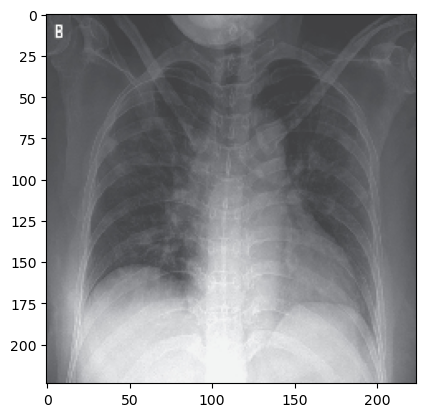

In [ ]:
plt.imshow(test_data[0][0][-1])
print(test_data[0][1][-1])

In [ ]:
test_data[3][0][-1]

array([[[0.41176474, 0.41176474, 0.41176474],
        [0.42352945, 0.42352945, 0.42352945],
        [0.44705886, 0.44705886, 0.44705886],
        ...,
        [0.5019608 , 0.5019608 , 0.5019608 ],
        [0.5686275 , 0.5686275 , 0.5686275 ],
        [0.6627451 , 0.6627451 , 0.6627451 ]],

       [[0.39607847, 0.39607847, 0.39607847],
        [0.40784317, 0.40784317, 0.40784317],
        [0.41960788, 0.41960788, 0.41960788],
        ...,
        [0.65882355, 0.65882355, 0.65882355],
        [0.6156863 , 0.6156863 , 0.6156863 ],
        [0.60784316, 0.60784316, 0.60784316]],

       [[0.41960788, 0.41960788, 0.41960788],
        [0.4039216 , 0.4039216 , 0.4039216 ],
        [0.41960788, 0.41960788, 0.41960788],
        ...,
        [0.62352943, 0.62352943, 0.62352943],
        [0.54901963, 0.54901963, 0.54901963],
        [0.44705886, 0.44705886, 0.44705886]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

[0. 1. 0.]


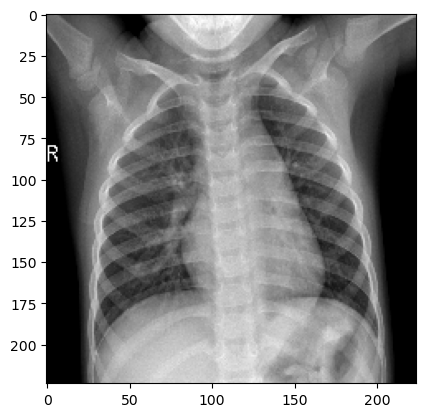

In [ ]:
plt.imshow(test_data[3][0][-1])
print(test_data[3][1][-1])

In [ ]:
val_data[1][0][-1]

array([[[0.3137255 , 0.3137255 , 0.3137255 ],
        [0.46274513, 0.46274513, 0.46274513],
        [0.5803922 , 0.5803922 , 0.5803922 ],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157]],

       [[0.29803923, 0.29803923, 0.29803923],
        [0.30980393, 0.30980393, 0.30980393],
        [0.45098042, 0.45098042, 0.45098042],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471]],

       [[0.29803923, 0.29803923, 0.29803923],
        [0.3019608 , 0.3019608 , 0.3019608 ],
        [0.32156864, 0.32156864, 0.32156864],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.01960784, 0.01960784, 0.01960784],
        [0.02352941, 0.02352941, 0.02352941]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0

[0. 0. 1.]


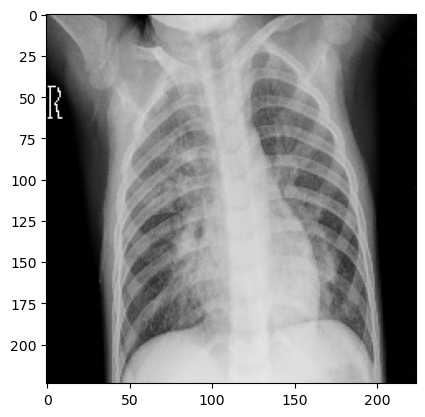

In [ ]:
plt.imshow(val_data[1][0][-1])
print(val_data[1][1][-1])

- **We Notice that all the images now are represnted as gray scale float arrays (normalized images).**

## **Class Weights**

- **We will Encounter the problem of Our Unbalanced Classes with Computing Class Weights**

In [ ]:
def getClassWeight(train_data):

    class_weights = compute_class_weight("balanced", classes = np.unique(train_data.labels),
                                         y = train_data.labels)

    class_weights = dict(zip(np.unique(np.unique(train_data.labels)), class_weights))
    
    return class_weights

In [ ]:
class_weights = getClassWeight(train_data)

class_weights

{0: 1.3522012578616351, 1: 0.8531746031746031, 2: 0.9188034188034188}

- **This Class Weights will help us during model training to force the model to not overfit the majority class or underfit the minority one. Hence not to be biased due to the unbalanced classes.**

# **Data Augmentation**

- **Now let's use the Data Generators to Augment the Data**

In [ ]:
def Plot_Norm_Aug(data_generator, Img_To_Aug, rows=3, cols=4):
    """
    Plots 4 images generated by an object of the ImageDataGenerator class.
    """
    data_generator.fit(Img_To_Aug)
    image_iterator = data_generator.flow(Img_To_Aug)
    
    # Plot the images given by the iterator
    fig, rows = plt.subplots(rows, cols, figsize=(30,15))
    
    for row in rows.flat:
        row.imshow(image_iterator.next()[0].astype('float'))
        #row.axis('off')
    plt.show()

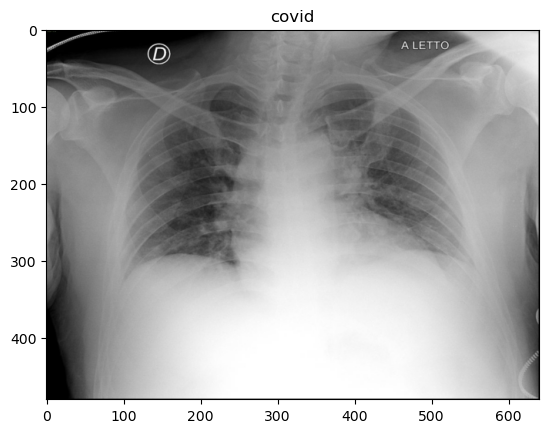

In [ ]:
ClassPath = '/kaggle/input/shai-level-2-training-2023/train/covid'

Random_Image = os.path.join(ClassPath, np.random.choice(os.listdir(ClassPath)))
    
image = plt.imread(Random_Image)

# Creating a dataset which contains just one image.
Test_Augment_Image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

plt.imshow(Test_Augment_Image[0])
plt.title('covid')
plt.show()

### **Applying Selected Augmentations**

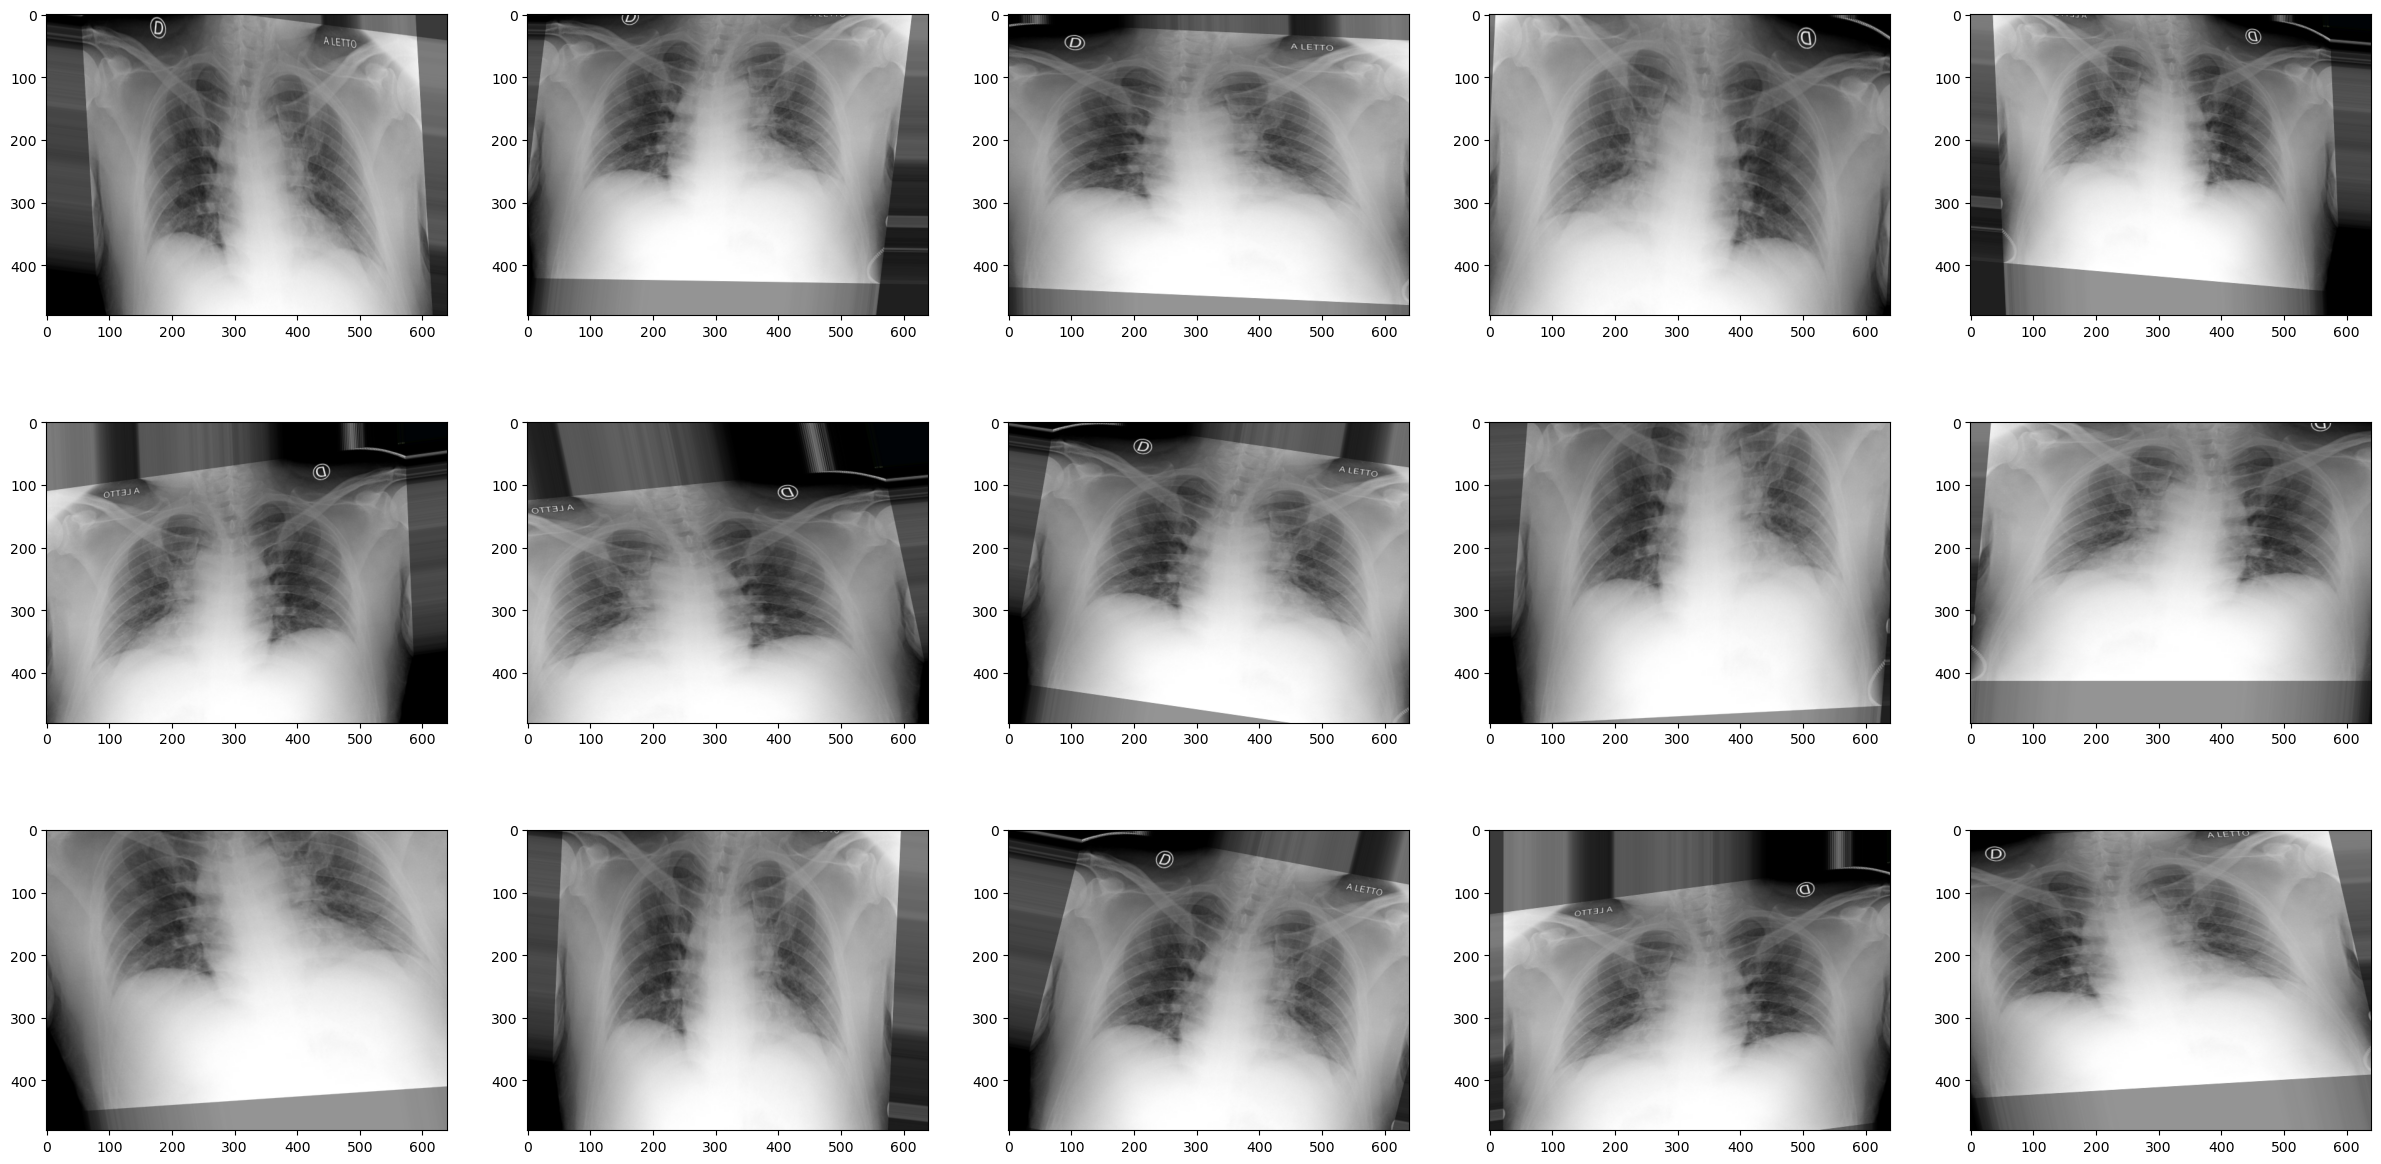

In [ ]:
train_preprocessor = ImageDataGenerator(
                                        zoom_range=(0.8, 1.2),
                                        rotation_range=10,                                        
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        shear_range=10,
                                        horizontal_flip=True,
                                        fill_mode='nearest'
                                        )

Plot_Norm_Aug(train_preprocessor, Test_Augment_Image, 3, 5)

- **Data Augmentation will help alot when training the model to reducing the effect of the overfitting that will sure there be due to the small size of the data.**

### **Creating Augmented Data**

In [ ]:
def Create_Aug_Datagens(batch_size, train_data_path, train_df, val_df, test_df):

    train_preprocessor = ImageDataGenerator(
                                        rescale = 1 / 255.,
                                                                                
                                        zoom_range=(0.8, 1.2),
                                        rotation_range=10,                                        
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        shear_range=10,
                                        horizontal_flip=True,
                                        fill_mode='nearest'
    )

    test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

    train_generator = train_preprocessor.flow_from_dataframe(
        dataframe=train_df,
        directory=train_data_path,
        x_col="Image",
        y_col="Label",
        class_mode="categorical",
        target_size=(img_shape,img_shape),
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size,
        seed=0
    )

    val_generator = test_preprocessor.flow_from_dataframe(
        dataframe=val_df,
        directory=train_data_path,
        x_col="Image",
        y_col="Label",
        class_mode="categorical",
        target_size=(img_shape,img_shape),
        color_mode="rgb",
        shuffle=False,
        batch_size=batch_size,
        seed=0
    )

    test_generator = test_preprocessor.flow_from_dataframe(
        dataframe=test_df,
        directory=train_data_path,
        x_col="Image",
        y_col="Label",
        class_mode="categorical",
        target_size=(img_shape,img_shape),
        color_mode="rgb",
        shuffle=False,
        batch_size=batch_size,
        seed=0
    )

    return train_generator, val_generator, test_generator

In [ ]:
# We will not consider the val set for now to be able to train more images for a higher score

train_df = pd.concat([train_df, val_df], axis=0)

train_df

Image   Label
45    /kaggle/input/shai-level-2-training-2023/train...   virus
42    /kaggle/input/shai-level-2-training-2023/train...   virus
338   /kaggle/input/shai-level-2-training-2023/train...   virus
812   /kaggle/input/shai-level-2-training-2023/train...  normal
17    /kaggle/input/shai-level-2-training-2023/train...  normal
...                                                 ...     ...
1081  /kaggle/input/shai-level-2-training-2023/train...   covid
804   /kaggle/input/shai-level-2-training-2023/train...   virus
304   /kaggle/input/shai-level-2-training-2023/train...   covid
197   /kaggle/input/shai-level-2-training-2023/train...   covid
1029  /kaggle/input/shai-level-2-training-2023/train...   virus

[980 rows x 2 columns]

In [ ]:
train_AugData, val_data , test_data = Create_Aug_Datagens(batch_size, TrainData_Dir, train_df, val_df, test_df)

Found 980 validated image filenames belonging to 3 classes.
Found 120 validated image filenames belonging to 3 classes.
Found 216 validated image filenames belonging to 3 classes.


- **Notice how the train data generator is diffierent from the val-test one to not augment them as well.**

# **Building CNN Model**

### **CNN Model Architecture**

- **We will try first Build A CNN with VGG like Archeticture.**

In [ ]:
def Create_CNN_Model():
    
    model = Sequential()
    
    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, color_type)))

    model.add(Conv2D(32,(3,3), activation='relu', padding='same'))

    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))


    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', ))

    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))

    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))


    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu'))

    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))

    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

    
    #CNN4
    model.add(Conv2D(256, (3,3), activation='relu'))

    model.add(Conv2D(256,(3,3), activation='relu', padding='same'))

    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    # model.add(Dropout(0.3))
    
    
    #Output
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense( Num_Classes , activation='softmax'))
  
    return model

In [ ]:
CNN_Model = Create_CNN_Model()

CNN_Model.summary()

CNN_Model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                    

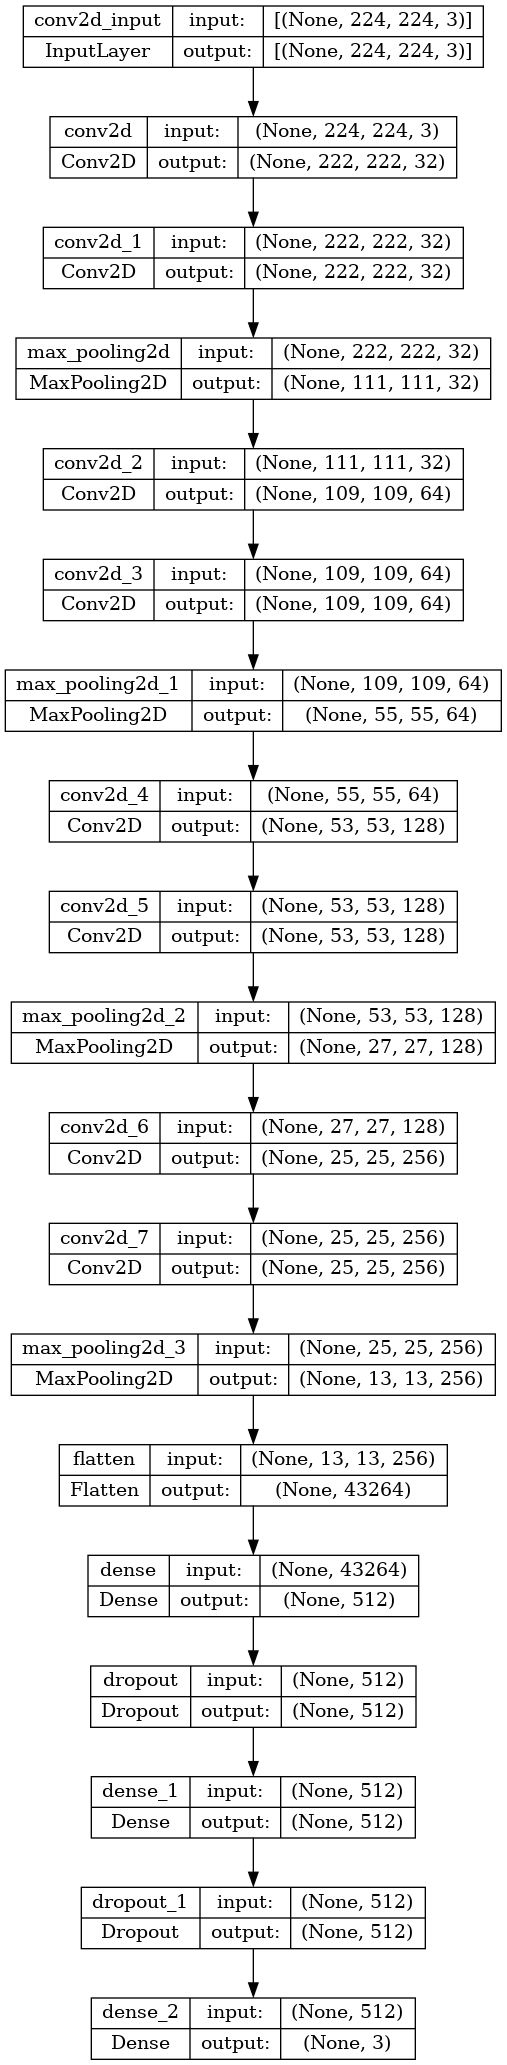

In [ ]:
plot_model(CNN_Model,"model.png", show_shapes=True, show_layer_names=True)

### **Specifying Callbacks**

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint.h5"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.5,
                                                  patience=3,
                                                  min_lr=0.00005,
                                                  verbose=1)

callbacks = [Checkpoint, Early_Stopping, Reducing_LR]

### **Fitting CNN Model**

In [ ]:
CNN_history = CNN_Model.fit(train_AugData , validation_data= test_data , epochs=50 , batch_size=batch_size, callbacks=callbacks)

Epoch 1/50
16/16 [==============================] - 60s 3s/step - loss: 1.0818 - accuracy: 0.3633 - val_loss: 1.0049 - val_accuracy: 0.3935 - lr: 0.0010
Epoch 2/50
16/16 [==============================] - 37s 2s/step - loss: 0.9827 - accuracy: 0.4806 - val_loss: 0.7452 - val_accuracy: 0.5787 - lr: 0.0010
Epoch 3/50
16/16 [==============================] - 35s 2s/step - loss: 0.7281 - accuracy: 0.6439 - val_loss: 0.6638 - val_accuracy: 0.6806 - lr: 0.0010
Epoch 4/50
16/16 [==============================] - 35s 2s/step - loss: 0.7373 - accuracy: 0.6602 - val_loss: 0.6161 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 5/50
16/16 [==============================] - 33s 2s/step - loss: 0.6336 - accuracy: 0.7122 - val_loss: 0.5960 - val_accuracy: 0.7176 - lr: 0.0010
Epoch 6/50
16/16 [==============================] - 33s 2s/step - loss: 0.6194 - accuracy: 0.7510 - val_loss: 0.6401 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 7/50
16/16 [==============================] - 34s 2s/step - loss: 0.5464 - a

In [ ]:
CNN_Scores = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Scores[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Scores[1] * 100))

4/4 [==============================] - 4s 885ms/step - loss: 0.1523 - accuracy: 0.9630
    Test Loss: 0.15233
Test Accuracy: 96.30%


- **The Custom CNN doesn't Overfit the Data but it also Underfits it, The training Accuaracy after 50 Epoches was about 94%, Perhaps it would increase with more epochs but it will not be a huge increase.**

- **That's Why Transfer Learning will be useful, with more complex model architectures it will be able to acheive fit the data better but it will be more prone to overfitting.**

### **Evaluating CNN Model**

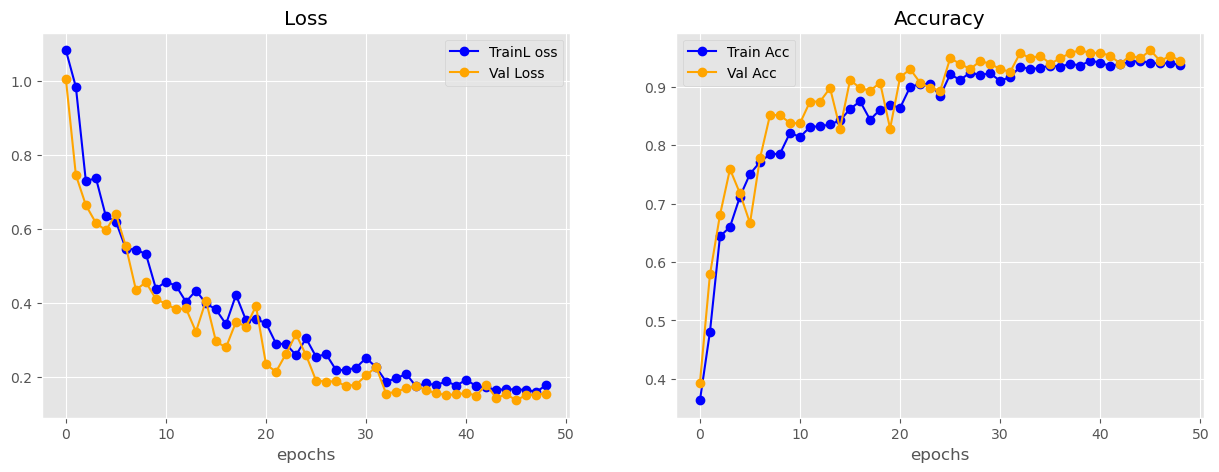

In [ ]:
plot_curves(CNN_history)

**Predicting the Test Set**

In [ ]:
CNN_Predictions_Probs = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
CNN_Predictions = np.argmax(CNN_Predictions_Probs, axis=1)

4/4 [==============================] - 4s 941ms/step


**Confusion Matrix**

[Text(0, 0.5, 'covid'), Text(0, 1.5, 'normal'), Text(0, 2.5, 'virus')]

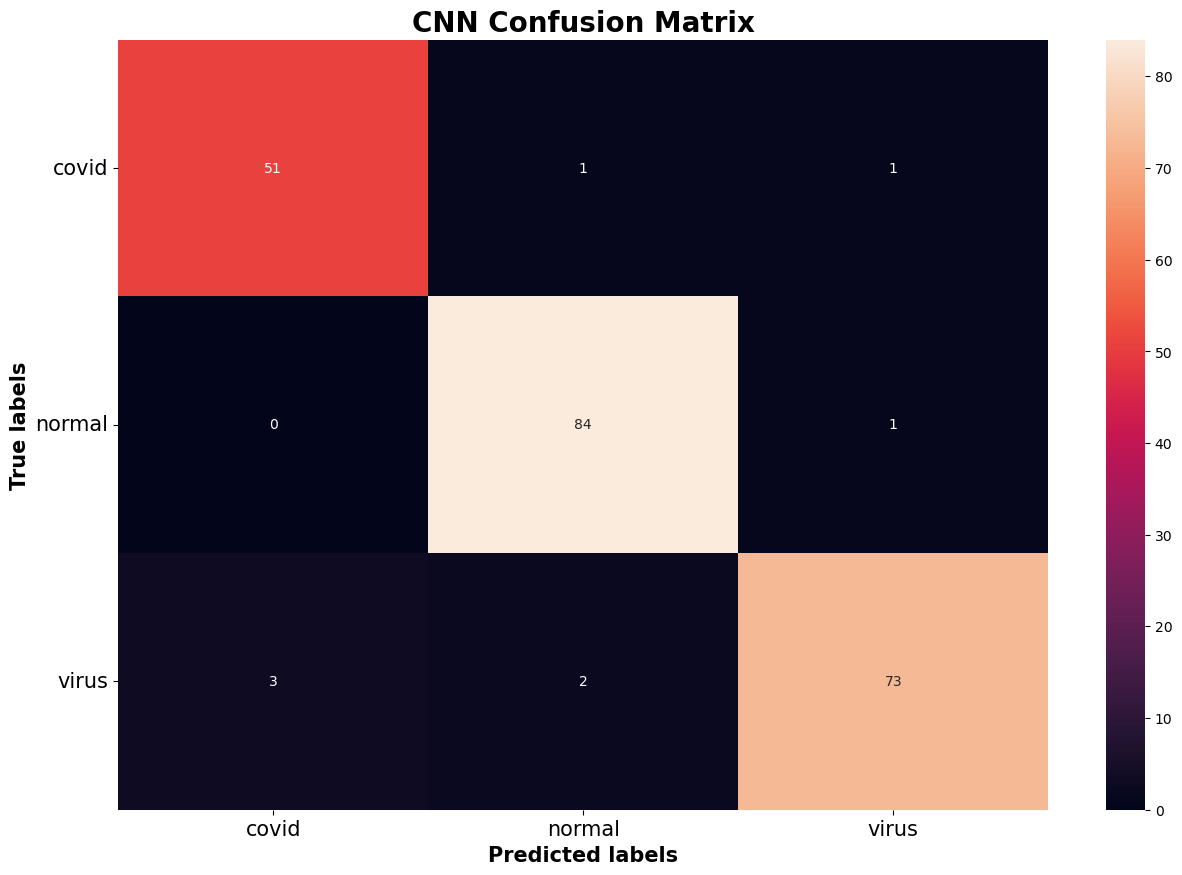

In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

ax.set_xticklabels(Covid_Classes , fontsize=15)
ax.set_yticklabels(Covid_Classes, rotation=0, fontsize=15)

**Classification Report**

In [ ]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(test_data.labels, CNN_Predictions, target_names= Covid_Classes)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

       covid       0.94      0.96      0.95        53
      normal       0.97      0.99      0.98        85
       virus       0.97      0.94      0.95        78

    accuracy                           0.96       216
   macro avg       0.96      0.96      0.96       216
weighted avg       0.96      0.96      0.96       216



In [ ]:
from sklearn.metrics import accuracy_score

print("Test Accuracy: {:.2f}%".format(accuracy_score(test_data.labels, CNN_Predictions) * 100))

Test Accuracy: 96.30%




---



# **DenseNet201 Pre-Trained Model**

### **Fine-Tuning DenseNet201 Model**

In [ ]:
from keras.applications.densenet import DenseNet201

DenseNet_201 = DenseNet201(input_shape=(224, 224, 3),
              include_top= False,
              weights='imagenet',
              )

DenseNet_201.summary()

#### **Freezing Layers**

In [ ]:
# Freezing all layers except last 50

DenseNet_201.trainable = True

Trainable_Layers = 50

for layer in DenseNet_201.layers[ : -Trainable_Layers ]:
    layer.trainable = False

DenseNet_201.summary()

### **Pre-Trained Model Architecture**

In [170]:
def Create_DenseNet201_Model():

  model = Sequential([
                        DenseNet_201,
      
                        ###########################################
      
                        GlobalAveragePooling2D(),
      
                        ###########################################

                        Dense(256, kernel_initializer="he_normal", activation = 'relu'),
                        Dropout(0.3),
      
                        Dense(256, kernel_initializer="he_normal", activation = 'relu'),
                        Dropout(0.3),
      
                        Dense(256, kernel_initializer="he_normal", activation = 'relu'),
                        Dropout(0.3),

                        Dense(256, kernel_initializer="he_normal", activation = 'relu'),
                        Dropout(0.5),
      
                        ###########################################

                        Dense(Num_Classes, activation = "softmax", kernel_initializer="GlorotUniform")
      
                    ])

  
  return model

In [171]:
DenseNet201_Model = Create_DenseNet201_Model()

# AdamW applies weight decay to prevent overfitting by penalizing large weights.  
optimizer = tf.keras.optimizers.experimental.AdamW(0.0001)

DenseNet201_Model.compile(optimizer= optimizer , loss='categorical_crossentropy', metrics=['accuracy'])

DenseNet201_Model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_8   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_61 (Dense)            (None, 256)               491776    
                                                                 
 dropout_45 (Dropout)        (None, 256)               0         
                                                                 
 dense_62 (Dense)            (None, 256)               65792     
                                                                 
 dropout_46 (Dropout)        (None, 256)               0         
                                                     

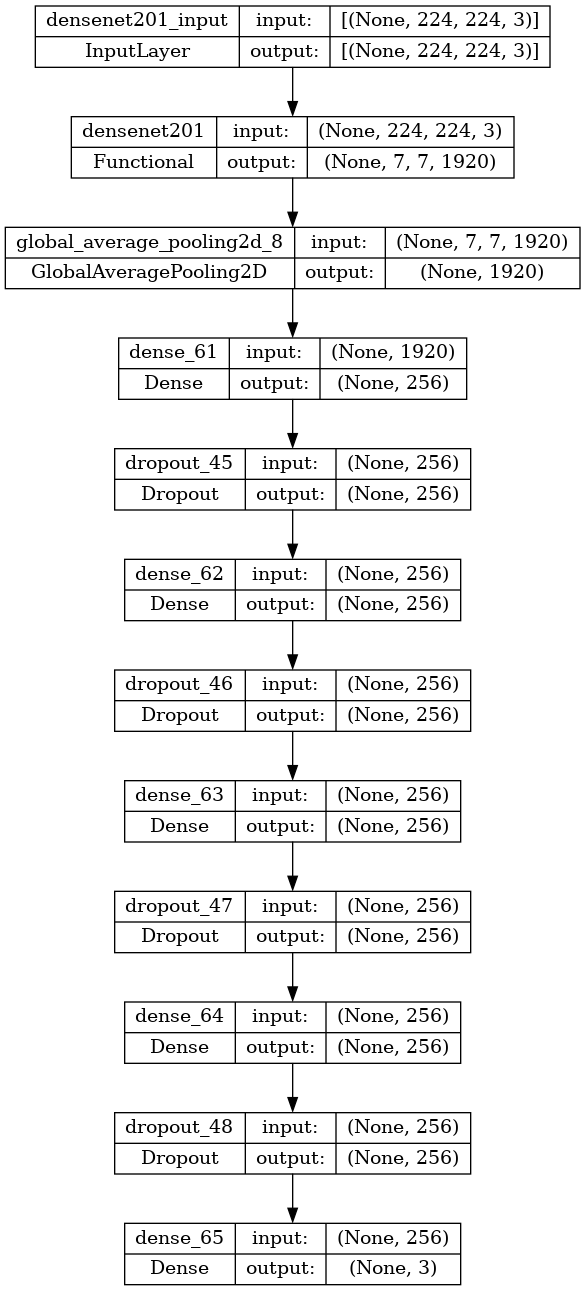

In [172]:
plot_model(DenseNet201_Model,"DenseNet201_Model.png", show_shapes=True, show_layer_names=True)

### **Specifying Callbacks**

In [ ]:
# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = ReduceLROnPlateau( monitor = "val_loss",
                                 patience = 3,
                                 verbose = 1,
                                 min_lr=0.00005,
                                 factor = 0.5,
                                 min_delta = 0.0001)

callbacks = [Early_Stopping, Reducing_LR]

### **Fitting DenseNet201 Model**

In [ ]:
DenseNet201_history = DenseNet201_Model.fit(train_AugData , validation_data = test_data, epochs=50,
                                            batch_size=batch_size, callbacks = callbacks, class_weight = class_weights)

16/16 [==============================] - 34s 2s/step - loss: 0.7610 - accuracy: 0.6296 - val_loss: 0.5657 - val_accuracy: 0.7824 - lr: 1.0000e-04
Epoch 4/50
16/16 [==============================] - 34s 2s/step - loss: 0.6700 - accuracy: 0.6949 - val_loss: 0.4437 - val_accuracy: 0.8472 - lr: 1.0000e-04
Epoch 5/50
16/16 [==============================] - 34s 2s/step - loss: 0.5431 - accuracy: 0.7561 - val_loss: 0.3841 - val_accuracy: 0.8611 - lr: 1.0000e-04
Epoch 6/50
16/16 [==============================] - 34s 2s/step - loss: 0.4584 - accuracy: 0.8153 - val_loss: 0.3286 - val_accuracy: 0.8796 - lr: 1.0000e-04
Epoch 7/50
16/16 [==============================] - 35s 2s/step - loss: 0.4268 - accuracy: 0.8265 - val_loss: 0.2732 - val_accuracy: 0.9074 - lr: 1.0000e-04
Epoch 8/50
16/16 [==============================] - 35s 2s/step - loss: 0.3942 - accuracy: 0.8439 - val_loss: 0.2295 - val_accuracy: 0.9213 - lr: 1.0000e-04
Epoch 9/50
16/16 [==============================] - 35s 2s/step - los

In [ ]:
DenseNet201_Scores = DenseNet201_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(DenseNet201_Scores[0]))
print("Test Accuracy: {:.2f}%".format(DenseNet201_Scores[1] * 100))

4/4 [==============================] - 5s 977ms/step - loss: 0.1149 - accuracy: 0.9676
    Test Loss: 0.11493
Test Accuracy: 96.76%


### **Evaluating Model**

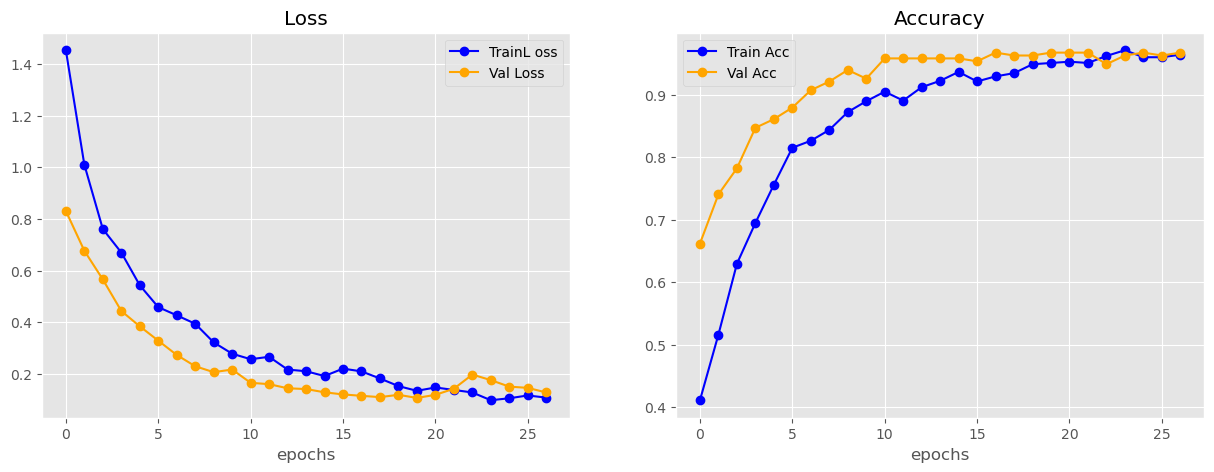

In [ ]:
plot_curves(DenseNet201_history)

**Predicting the Test Set**

In [ ]:
DenseNet201_Predictions_Probs = DenseNet201_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
DenseNet201_Predictions = np.argmax(DenseNet201_Predictions_Probs, axis=1)

4/4 [==============================] - 8s 1s/step


**Confusion Matrix**

[Text(0, 0.5, 'covid'), Text(0, 1.5, 'normal'), Text(0, 2.5, 'virus')]

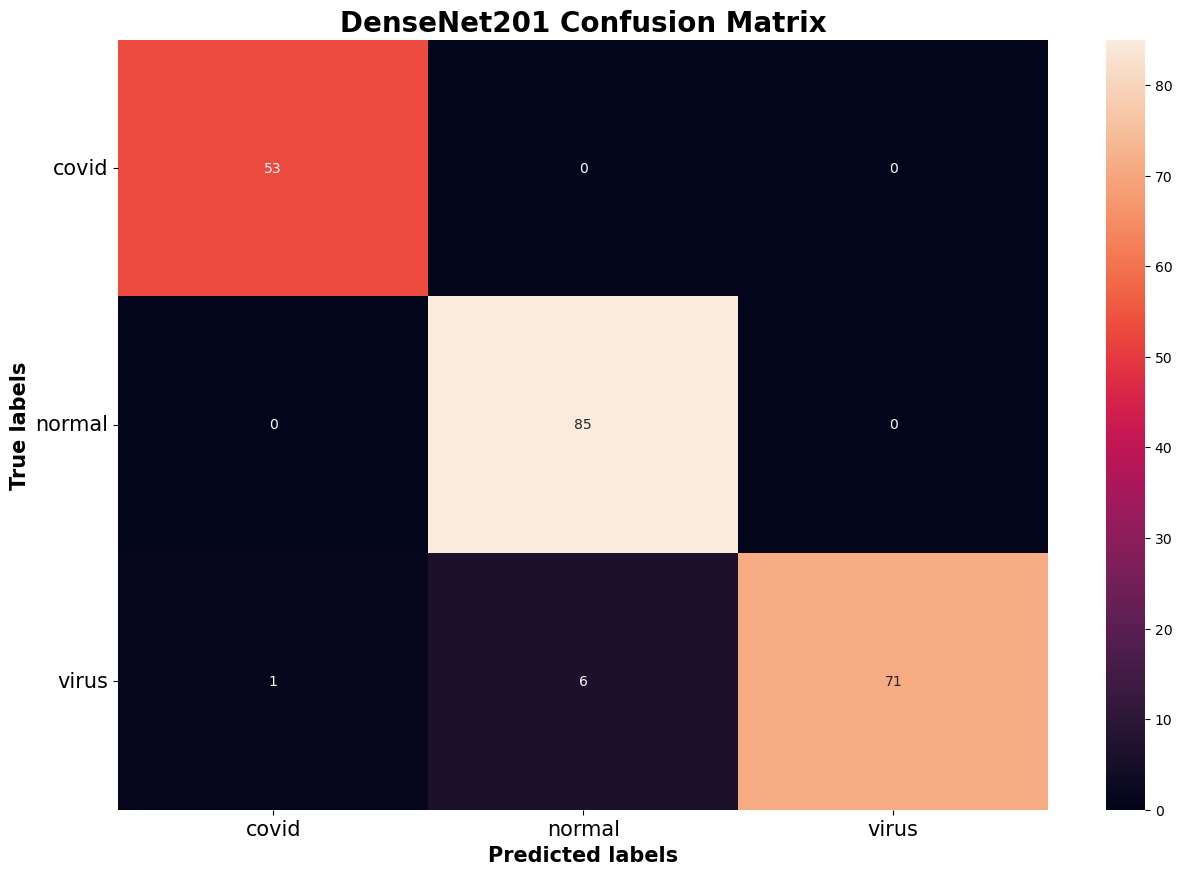

In [ ]:
fig , ax= plt.subplots(figsize=(15,10))

cm = confusion_matrix(test_data.labels, DenseNet201_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')

ax.set_title('DenseNet201 Confusion Matrix', fontsize=20, fontweight='bold')

ax.set_xticklabels(Covid_Classes , fontsize=15)
ax.set_yticklabels(Covid_Classes, rotation=0, fontsize=15)

**Classification report**

In [ ]:
ClassificationReport = classification_report(test_data.labels, DenseNet201_Predictions, target_names= Covid_Classes)

print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

       covid       0.98      1.00      0.99        53
      normal       0.93      1.00      0.97        85
       virus       1.00      0.91      0.95        78

    accuracy                           0.97       216
   macro avg       0.97      0.97      0.97       216
weighted avg       0.97      0.97      0.97       216



In [ ]:
print("Test Accuracy: {:.2f}%".format(accuracy_score(test_data.labels, DenseNet201_Predictions) * 100))

Test Accuracy: 96.76%


- **DenseNet201 May not gave far better accuaracy than our CNN, but it gave better F1 Score and we care more about this metric since our classes is not balanced.**

# **InceptionV3 Pre-Trained Model**

### **Fine-Tuning InceptionV3 Model**

In [ ]:
from keras.applications.inception_v3 import InceptionV3

Inception_V3 = InceptionV3(input_shape=(224, 224, 3),
              include_top= False,
              weights='imagenet',
              )

Inception_V3.summary()

#### **Freezing Layers**

In [ ]:
# Freezing all layers except last 100

Inception_V3.trainable = True

Trainable_Layers = 100

for layer in Inception_V3.layers[ : -Trainable_Layers ]:
    layer.trainable = False

Inception_V3.summary()

### **Pre-Trained Model Architecture**

In [ ]:
def Create_InceptionV3_Model():

  model = Sequential([
                        Inception_V3,
                      
                        BatchNormalization(renorm=True),
      
                        ###########################################
      
                        GlobalAveragePooling2D(),
      
                        ###########################################

                        Dense(256, kernel_initializer="he_normal", activation = 'relu'),
                        Dropout(0.3),
                      
                        Dense(256, kernel_initializer="he_normal", activation = 'relu'),
                        Dropout(0.3),
      
                        Dense(256, kernel_initializer="he_normal", activation = 'relu'),
                        Dropout(0.3),      

                        Dense(256, kernel_initializer="he_normal", activation = 'relu'),
                        Dropout(0.5),
      
                        ###########################################

                        Dense(Num_Classes, activation = "softmax", kernel_initializer="GlorotUniform")
      
                    ])

  
  return model

In [ ]:
InceptionV3_Model = Create_InceptionV3_Model()

optimizer = tf.keras.optimizers.experimental.AdamW(0.0001)

InceptionV3_Model.compile(optimizer= optimizer , loss='categorical_crossentropy', metrics=['accuracy'])

InceptionV3_Model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 batch_normalization_582 (Ba  (None, 5, 5, 2048)       14336     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d_18  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_86 (Dense)            (None, 256)               524544    
                                                                 
 dropout_67 (Dropout)        (None, 256)               0         
                                                                 
 dense_87 (Dense)            (None, 256)             

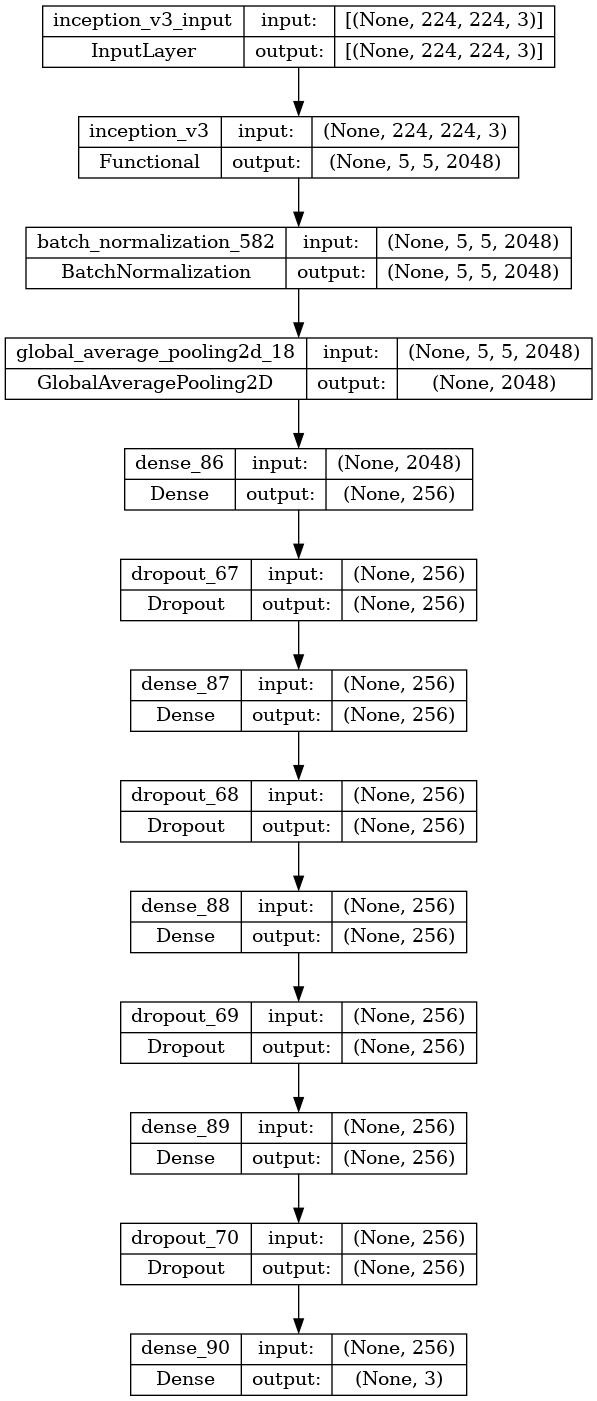

In [ ]:
plot_model(InceptionV3_Model,"InceptionV3_Model.png", show_shapes=True, show_layer_names=True)

### **Specifying Callbacks**

In [ ]:
# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = ReduceLROnPlateau( monitor = "val_loss",
                                 patience = 3,
                                 verbose = 1,
                                 min_lr=0.00005,
                                 factor = 0.5,
                                 min_delta = 0.0001)

callbacks = [Early_Stopping, Reducing_LR]

### **Fitting InceptionV3 Model**

In [ ]:
InceptionV3_history = InceptionV3_Model.fit(train_AugData , validation_data = test_data, epochs=50,
                                            batch_size=batch_size, callbacks = callbacks, class_weight = class_weights)

Epoch 1/50
16/16 [==============================] - 52s 2s/step - loss: 1.2125 - accuracy: 0.4306 - val_loss: 0.8940 - val_accuracy: 0.4861 - lr: 1.0000e-04
Epoch 2/50
16/16 [==============================] - 33s 2s/step - loss: 1.0266 - accuracy: 0.5020 - val_loss: 1.0198 - val_accuracy: 0.4676 - lr: 1.0000e-04
Epoch 3/50
16/16 [==============================] - 33s 2s/step - loss: 0.7449 - accuracy: 0.6673 - val_loss: 1.3714 - val_accuracy: 0.4954 - lr: 1.0000e-04
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 0.5451 - accuracy: 0.7571
Epoch 4: ReduceLROnPlateau reducing learning rate to 5e-05.
16/16 [==============================] - 33s 2s/step - loss: 0.5451 - accuracy: 0.7571 - val_loss: 1.5432 - val_accuracy: 0.5787 - lr: 1.0000e-04
Epoch 5/50
16/16 [==============================] - 34s 2s/step - loss: 0.4889 - accuracy: 0.8071 - val_loss: 1.4043 - val_accuracy: 0.6296 - lr: 5.0000e-05
Epoch 6/50
16/16 [==============================] - 33s 2s/step - loss: 

In [ ]:
InceptionV3_Scores = InceptionV3_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(InceptionV3_Scores[0]))
print("Test Accuracy: {:.2f}%".format(InceptionV3_Scores[1] * 100))

4/4 [==============================] - 4s 947ms/step - loss: 0.2277 - accuracy: 0.9769
    Test Loss: 0.22774
Test Accuracy: 97.69%


### **Evaluating Model**

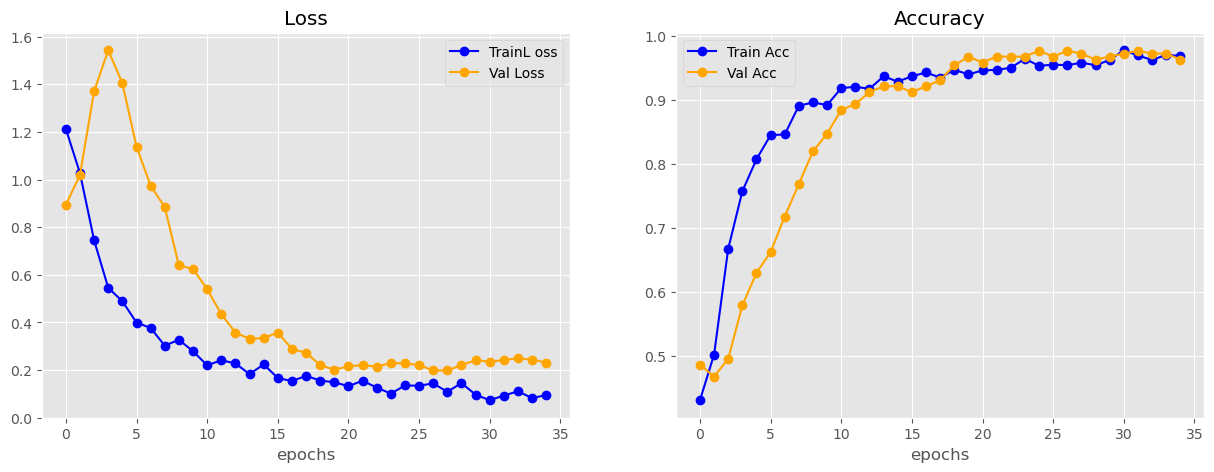

In [ ]:
plot_curves(InceptionV3_history)

**Predicting the Test Set**

In [ ]:
InceptionV3_Predictions_Probs = InceptionV3_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
InceptionV3_Predictions = np.argmax(InceptionV3_Predictions_Probs, axis=1)

4/4 [==============================] - 6s 1s/step


**Confusion Matrix**

[Text(0, 0.5, 'covid'), Text(0, 1.5, 'normal'), Text(0, 2.5, 'virus')]

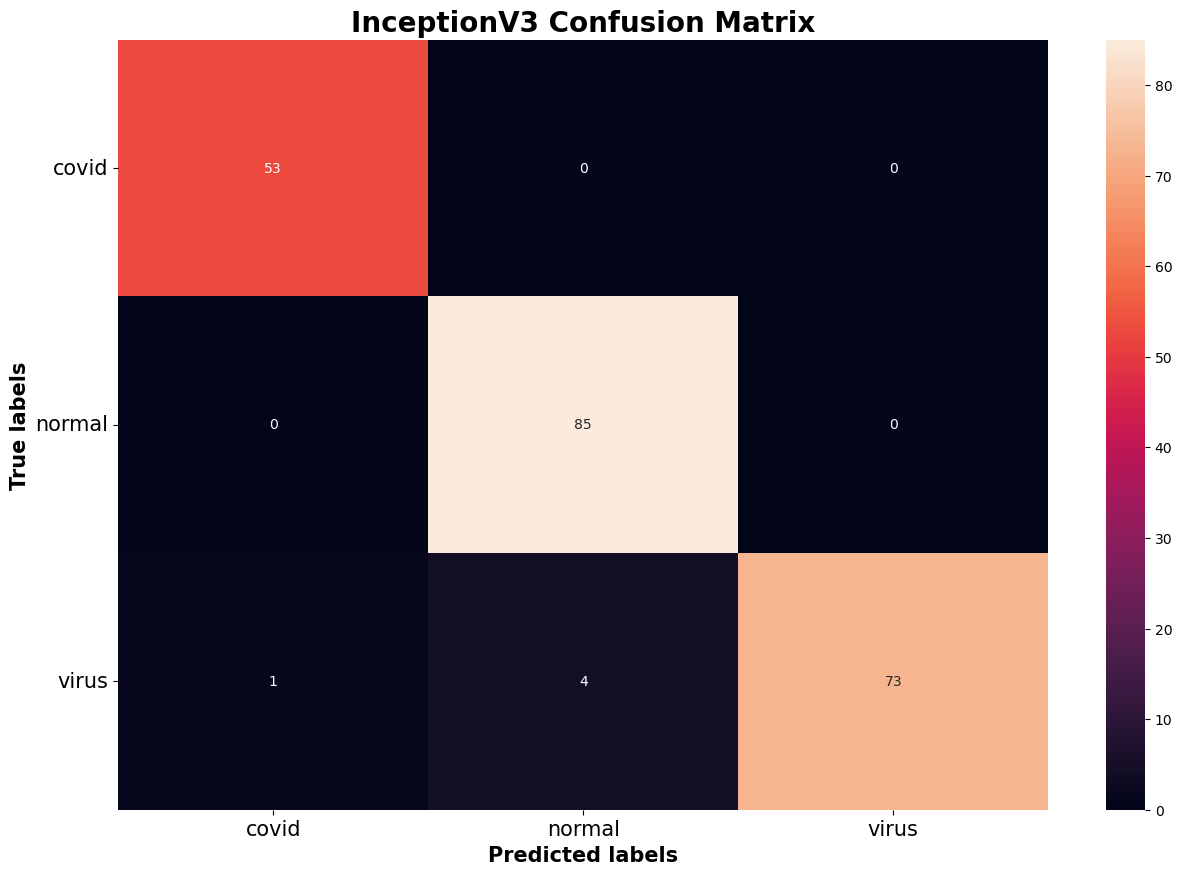

In [ ]:
fig , ax= plt.subplots(figsize=(15,10))

cm = confusion_matrix(test_data.labels, InceptionV3_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')

ax.set_title('InceptionV3 Confusion Matrix', fontsize=20, fontweight='bold')

ax.set_xticklabels(Covid_Classes , fontsize=15)
ax.set_yticklabels(Covid_Classes, rotation=0, fontsize=15)

**Classification report**

In [ ]:
ClassificationReport = classification_report(test_data.labels, InceptionV3_Predictions, target_names= Covid_Classes)

print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

       covid       0.98      1.00      0.99        53
      normal       0.96      1.00      0.98        85
       virus       1.00      0.94      0.97        78

    accuracy                           0.98       216
   macro avg       0.98      0.98      0.98       216
weighted avg       0.98      0.98      0.98       216



In [ ]:
print("Test Accuracy: {:.2f}%".format(accuracy_score(test_data.labels, InceptionV3_Predictions) * 100))

Test Accuracy: 97.69%


- **InceptionV3 Gave Outstanding Results with 98% F1 Score, But will see if we can get better with other networks.**

# **InceptionResNetV2 Pre-Trained Model**

### **Fine-Tuning InceptionResNetV2 Model**

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

InceptionResNet_V2 = InceptionResNetV2(input_shape=(224, 224, 3),
              include_top= False,
              weights='imagenet',
              )

InceptionResNet_V2.summary()

#### **Freezing Layers**

In [ ]:
## Freezing all layers except last 50

InceptionResNet_V2.trainable = True

Trainable_Layers = 100

for layer in InceptionResNet_V2.layers[ : -Trainable_Layers ]:
    layer.trainable = False

InceptionResNet_V2.summary()

### **Pre-Trained Model Architecture**

In [ ]:
def Create_InceptionResNetV2_Model():

  model = Sequential([
                        InceptionResNet_V2,
      
                        BatchNormalization(renorm=True),
      
                        ###########################################
      
                        GlobalAveragePooling2D(),
      
                        ###########################################

                        Dense(128, kernel_initializer="he_normal", activation = 'relu'),
                        Dropout(0.3),
                      
                        Dense(128, kernel_initializer="he_normal", activation = 'relu'),
                        Dropout(0.3),
      
                        Dense(128, kernel_initializer="he_normal", activation = 'relu'),
                        Dropout(0.3),      

                        Dense(128, kernel_initializer="he_normal", activation = 'relu'),
                        Dropout(0.5),
      
                        ###########################################

                        Dense(Num_Classes, activation = "softmax", kernel_initializer="GlorotUniform")
      
                    ])

  
  return model

In [ ]:
InceptionResNetV2_Model = Create_InceptionResNetV2_Model()

optimizer = tf.keras.optimizers.Adam(0.0001)

InceptionResNetV2_Model.compile(optimizer= optimizer , loss='categorical_crossentropy', metrics=['accuracy'])

InceptionResNetV2_Model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_1834 (B  (None, 5, 5, 1536)       10752     
 atchNormalization)                                              
                                                                 
 global_average_pooling2d_7   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_56 (Dense)            (None, 128)               196736    
                                                                 
 dropout_41 (Dropout)        (None, 128)               0         
                                                     

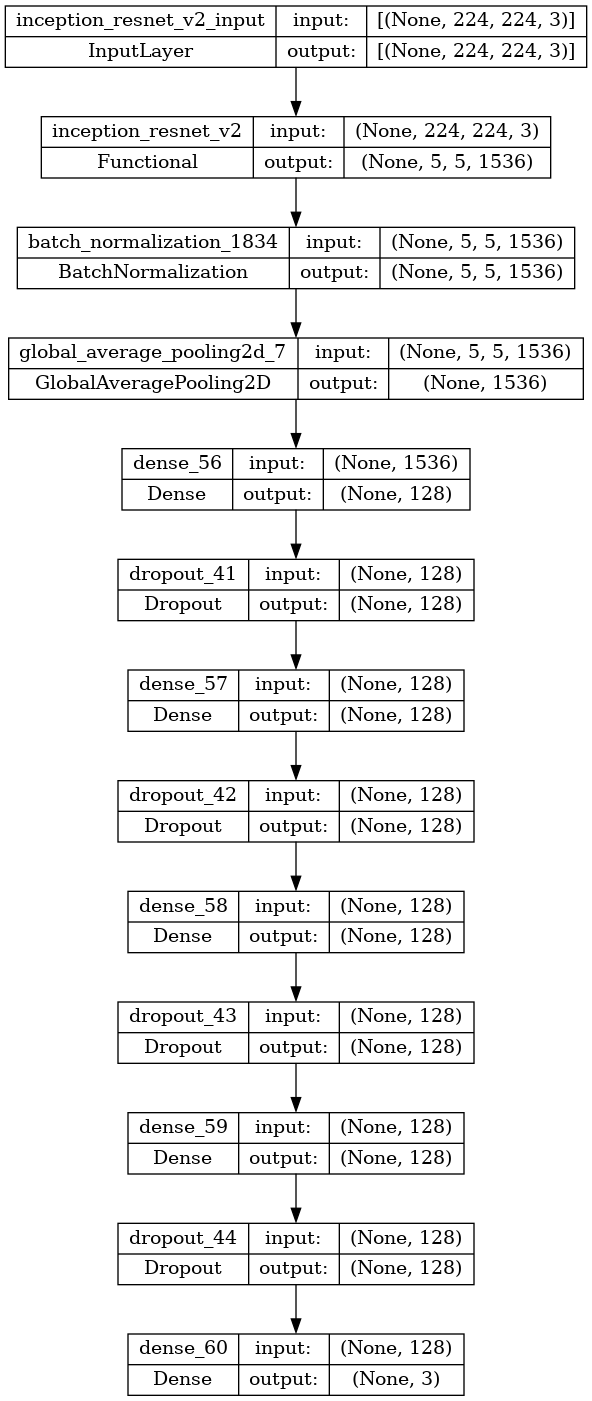

In [ ]:
plot_model(InceptionResNetV2_Model,"InceptionResNetV2_Model.png", show_shapes=True, show_layer_names=True)

### **Specifying Callbacks**

In [ ]:
# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = ReduceLROnPlateau( monitor = "val_loss",
                                 patience = 3,
                                 verbose = 1,
                                 min_lr=0.00005,
                                 factor = 0.5,
                                 min_delta = 0.0001)

callbacks = [Early_Stopping, Reducing_LR]

### **Fitting InceptionResNetV2 Model**

In [ ]:
InceptionResNetV2_history = InceptionResNetV2_Model.fit(train_AugData , validation_data = test_data, epochs=50,
                                            batch_size=batch_size, callbacks = callbacks, class_weight = class_weights)

Epoch 1/50
16/16 [==============================] - 63s 2s/step - loss: 1.1823 - accuracy: 0.4000 - val_loss: 0.9276 - val_accuracy: 0.4815 - lr: 1.0000e-04
Epoch 2/50
16/16 [==============================] - 37s 2s/step - loss: 0.9810 - accuracy: 0.4959 - val_loss: 0.7657 - val_accuracy: 0.6852 - lr: 1.0000e-04
Epoch 3/50
16/16 [==============================] - 37s 2s/step - loss: 0.8200 - accuracy: 0.6051 - val_loss: 0.5781 - val_accuracy: 0.8241 - lr: 1.0000e-04
Epoch 4/50
16/16 [==============================] - 36s 2s/step - loss: 0.6630 - accuracy: 0.7112 - val_loss: 0.6973 - val_accuracy: 0.6759 - lr: 1.0000e-04
Epoch 5/50
16/16 [==============================] - 36s 2s/step - loss: 0.5268 - accuracy: 0.7653 - val_loss: 0.5716 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 6/50
16/16 [==============================] - 37s 2s/step - loss: 0.4653 - accuracy: 0.8204 - val_loss: 0.5454 - val_accuracy: 0.7917 - lr: 1.0000e-04
Epoch 7/50
16/16 [==============================] - 37s 2s

In [ ]:
InceptionResNetV2_Scores = InceptionResNetV2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(InceptionResNetV2_Scores[0]))
print("Test Accuracy: {:.2f}%".format(InceptionResNetV2_Scores[1] * 100))

4/4 [==============================] - 5s 1s/step - loss: 0.1754 - accuracy: 0.9722
    Test Loss: 0.17537
Test Accuracy: 97.22%


### **Evaluating Model**

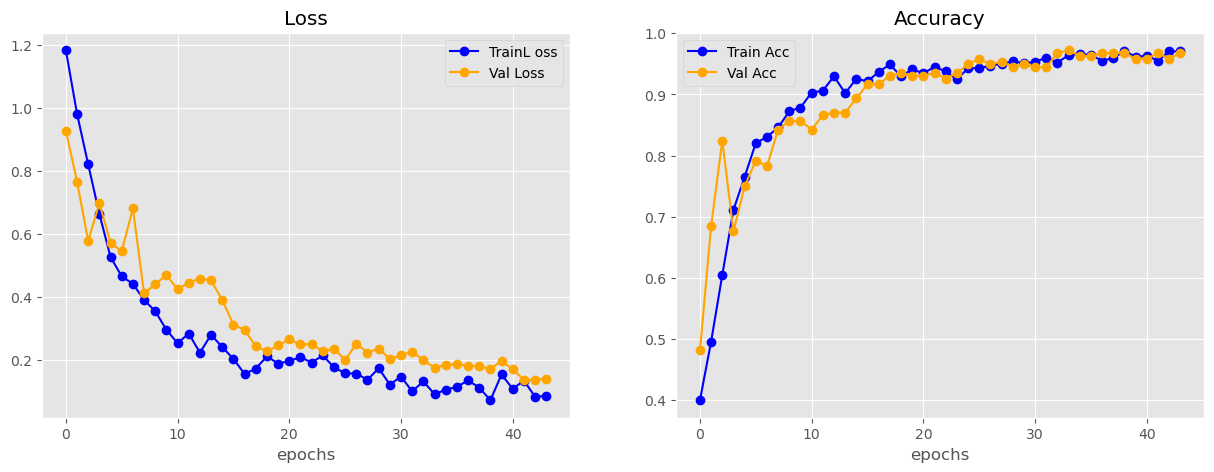

In [ ]:
plot_curves(InceptionResNetV2_history)

**Predicting the Test Set**

In [ ]:
InceptionResNetV2_Predictions_Probs = InceptionResNetV2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
InceptionResNetV2_Predictions = np.argmax(InceptionResNetV2_Predictions_Probs, axis=1)

4/4 [==============================] - 5s 1s/step


**Confusion Matrix**

[Text(0, 0.5, 'covid'), Text(0, 1.5, 'normal'), Text(0, 2.5, 'virus')]

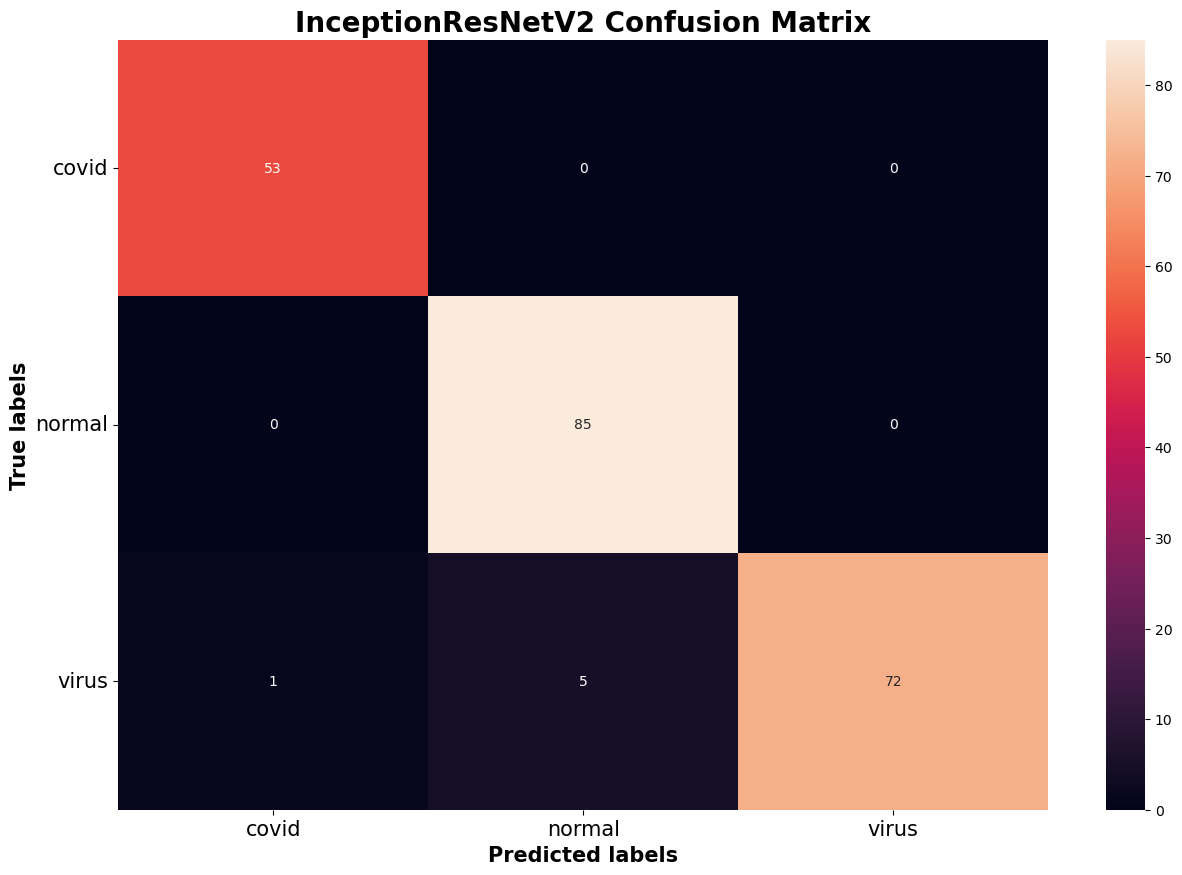

In [ ]:
fig , ax= plt.subplots(figsize=(15,10))

cm = confusion_matrix(test_data.labels, InceptionResNetV2_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')

ax.set_title('InceptionResNetV2 Confusion Matrix', fontsize=20, fontweight='bold')

ax.set_xticklabels(Covid_Classes , fontsize=15)
ax.set_yticklabels(Covid_Classes, rotation=0, fontsize=15)

**Classification report**

In [ ]:
ClassificationReport = classification_report(test_data.labels, InceptionResNetV2_Predictions, target_names= Covid_Classes)

print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

       covid       0.98      1.00      0.99        53
      normal       0.94      1.00      0.97        85
       virus       1.00      0.92      0.96        78

    accuracy                           0.97       216
   macro avg       0.98      0.97      0.97       216
weighted avg       0.97      0.97      0.97       216



In [ ]:
print("Test Accuracy: {:.2f}%".format(accuracy_score(test_data.labels, InceptionResNetV2_Predictions) * 100))

Test Accuracy: 97.22%


- **Although InceptionResNetV2 is far complex and deep than the two previous networks, it didn't perform better than the others.**

# **VGG-16 Pre-Trained Model**

### **Fine-Tuning VGG16 Model**

In [ ]:
from keras.applications.vgg16 import VGG16

# 224,224,3
VGG_16 = VGG16(input_shape=(224, 224, 3),
              include_top= False,
              weights='imagenet',
              )

VGG_16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

#### **Freezing Layers**

- **We will Re-Train most of the layers since `'ImageNet'` doesn't have images similar to our dataset, So we will benefit more from vgg-16 archeticture rather than it's pre-trained weights.**

In [ ]:
# Freezing all layers except last 10

VGG_16.trainable = True

Trainable_Layers = 10

for layer in VGG_16.layers[ : -Trainable_Layers ]:
    layer.trainable = False

VGG_16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### **Pre-Trained Model Architecture**

In [ ]:
def Create_VGG16_Model():

  model = Sequential([
                      VGG_16,
 
                      ###########################################

                      GlobalAveragePooling2D(),

                      ###########################################
                      Dense(256, activation='relu'),
                      Dropout(0.3),

                      Dense(256, activation='relu'),
                      Dropout(0.3),

                      Dense(256, activation='relu'),
                      Dropout(0.3),

                      Dense(256, activation='relu'),
                      Dropout(0.5),

                      ##########################################
                      Dense( Num_Classes, activation='softmax')
                    ])
  
  return model

In [ ]:
VGG16_Model = Create_VGG16_Model()

VGG16_Model.summary()

# Setting low learning rate because the weights are already trained before
optimizer = keras.optimizers.Adam(0.0001)

VGG16_Model.compile(optimizer= optimizer , loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

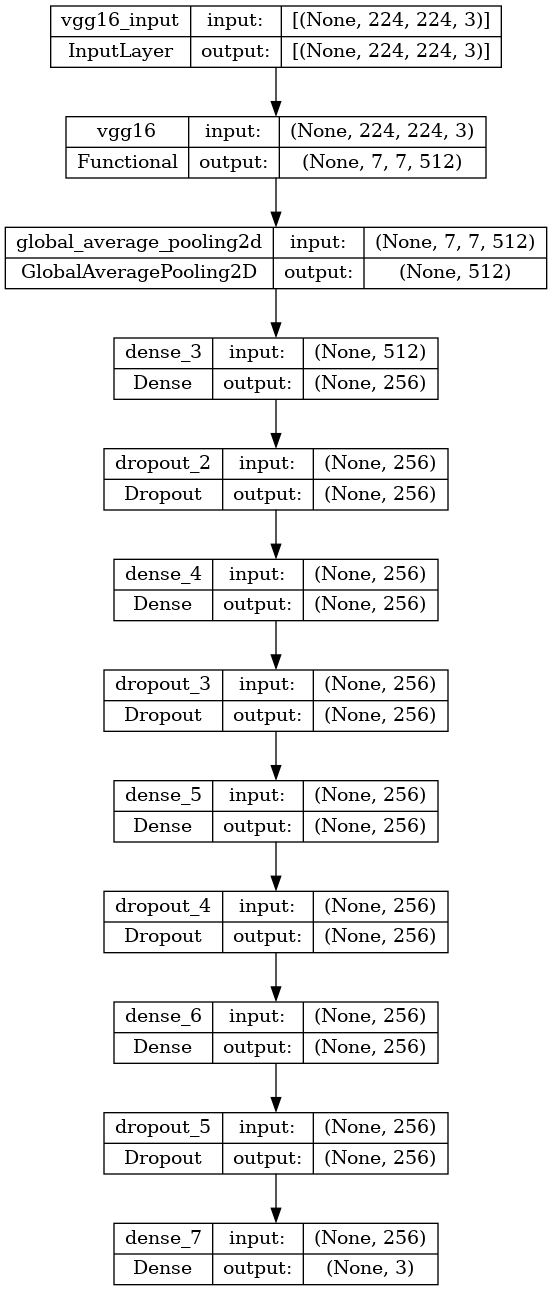

In [ ]:
plot_model(VGG16_Model,"VGG_Model.png", show_shapes=True, show_layer_names=True)

### **Specifying Callbacks**

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "VGG16_Model_Checkpoint.h5"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.5,
                                                  patience=3,
                                                  min_lr=0.00005,
                                                  verbose=1)

callbacks = [Checkpoint, Early_Stopping, Reducing_LR]

### **Fitting VGG16 Model**

In [ ]:
VGG16_history = VGG16_Model.fit(train_AugData ,validation_data = test_data , epochs=50 , batch_size=batch_size, callbacks = callbacks)

Epoch 1/50
18/18 [==============================] - 41s 2s/step - loss: 0.1666 - accuracy: 0.9509 - val_loss: 0.2736 - val_accuracy: 0.9120 - lr: 5.0000e-05
Epoch 2/50
18/18 [==============================] - 38s 2s/step - loss: 0.1779 - accuracy: 0.9436 - val_loss: 0.2047 - val_accuracy: 0.9398 - lr: 5.0000e-05
Epoch 3/50
18/18 [==============================] - 37s 2s/step - loss: 0.1327 - accuracy: 0.9627 - val_loss: 0.1450 - val_accuracy: 0.9583 - lr: 5.0000e-05
Epoch 4/50
18/18 [==============================] - 37s 2s/step - loss: 0.1926 - accuracy: 0.9455 - val_loss: 0.3823 - val_accuracy: 0.8750 - lr: 5.0000e-05
Epoch 5/50
18/18 [==============================] - 38s 2s/step - loss: 0.1517 - accuracy: 0.9573 - val_loss: 0.1213 - val_accuracy: 0.9722 - lr: 5.0000e-05
Epoch 6/50
18/18 [==============================] - 37s 2s/step - loss: 0.1345 - accuracy: 0.9664 - val_loss: 0.2716 - val_accuracy: 0.9259 - lr: 5.0000e-05
Epoch 7/50
18/18 [==============================] - 38s 2s

In [ ]:
VGG16_Scores = VGG16_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(VGG16_Scores[0]))
print("Test Accuracy: {:.2f}%".format(VGG16_Scores[1] * 100))

4/4 [==============================] - 4s 949ms/step - loss: 0.0994 - accuracy: 0.9861
    Test Loss: 0.09943
Test Accuracy: 98.61%


### **Evaluating Model**

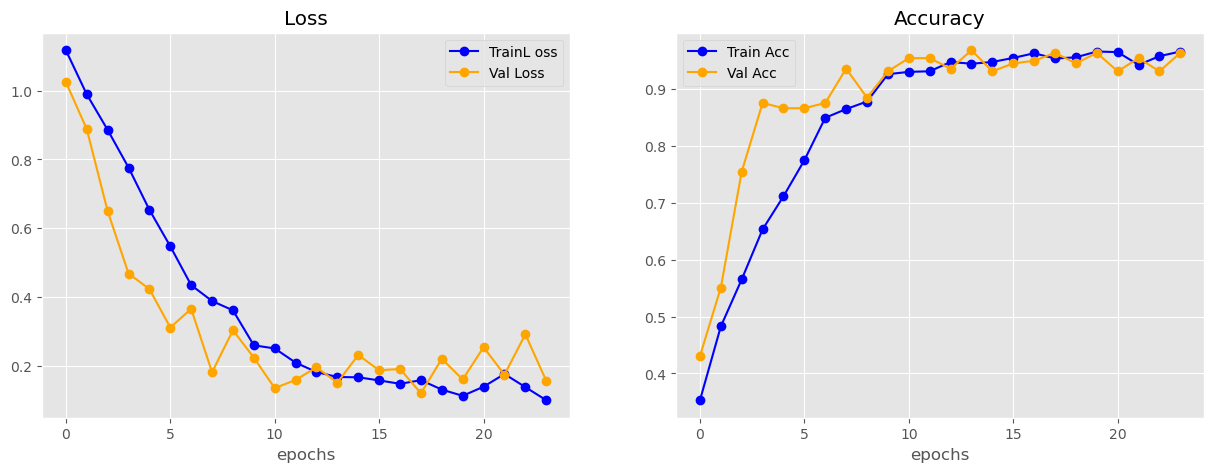

In [ ]:
plot_curves(VGG16_history)

**Predicting the Test Set**

In [ ]:
VGG16_Predictions_Probs = VGG16_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
VGG16_Predictions = np.argmax(VGG16_Predictions_Probs, axis=1)

4/4 [==============================] - 4s 966ms/step


**Confusion Matrix**

[Text(0, 0.5, 'covid'), Text(0, 1.5, 'normal'), Text(0, 2.5, 'virus')]

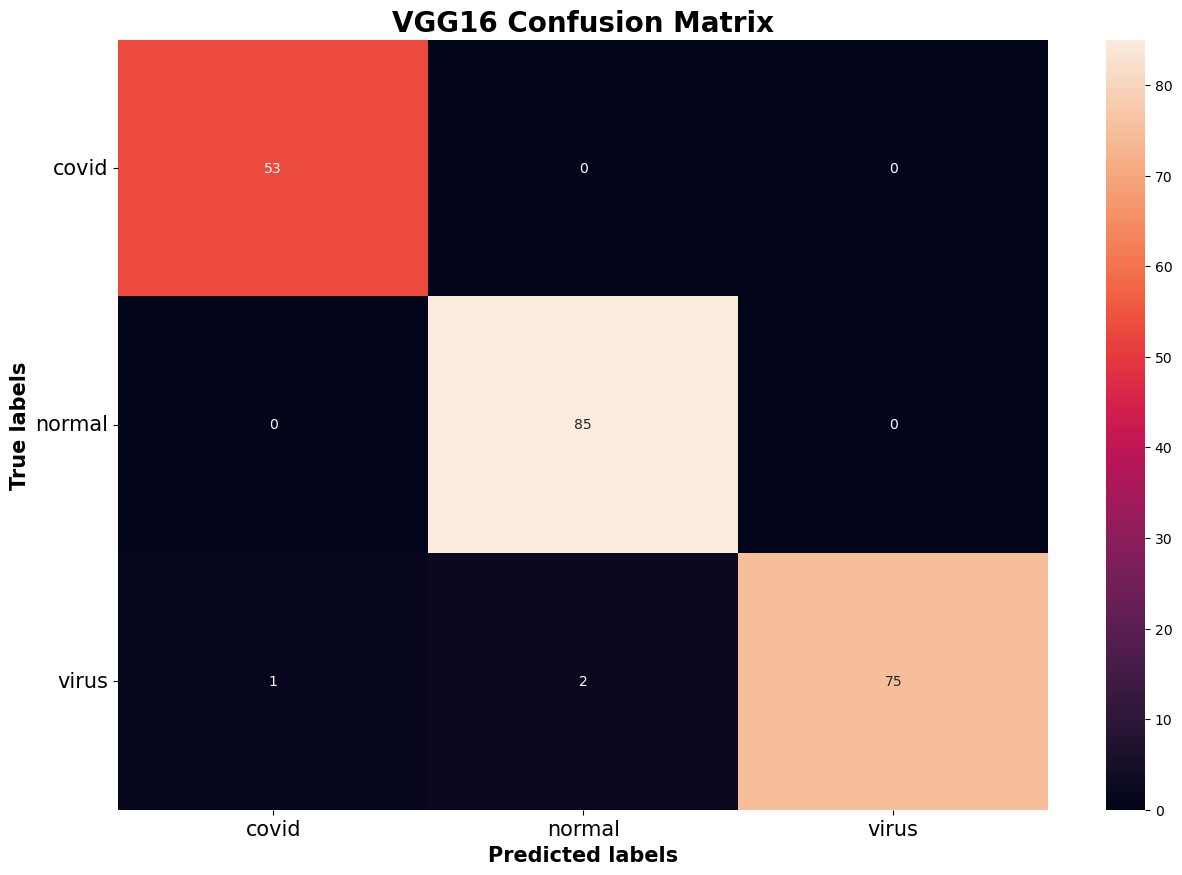

In [ ]:
fig , ax= plt.subplots(figsize=(15,10))

cm = confusion_matrix(test_data.labels, VGG16_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')

ax.set_title('VGG16 Confusion Matrix', fontsize=20, fontweight='bold')

ax.set_xticklabels(Covid_Classes , fontsize=15)
ax.set_yticklabels(Covid_Classes, rotation=0, fontsize=15)

**Classification Report**

In [ ]:
ClassificationReport = classification_report(test_data.labels, VGG16_Predictions, target_names= Covid_Classes)

print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

       covid       0.98      1.00      0.99        53
      normal       0.98      1.00      0.99        85
       virus       1.00      0.96      0.98        78

    accuracy                           0.99       216
   macro avg       0.99      0.99      0.99       216
weighted avg       0.99      0.99      0.99       216



In [ ]:
from sklearn.metrics import accuracy_score

print("Test Accuracy: {:.2f}%".format(accuracy_score(test_data.labels, VGG16_Predictions) * 100))

Test Accuracy: 98.61%


- **Outstandingly, VGG-16 Gave the Best Performence with 98.6% Accuracy and 99% F1 Score!**

# **Visualizing Predictions**

**Shuffling Test Data to show diffrent classes**

In [ ]:
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_dataframe(
        dataframe=test_df,
        directory=TrainData_Dir,
        x_col="Image",
        y_col="Label",
        class_mode="categorical",
        target_size=(img_shape,img_shape),
        color_mode="rgb",
        shuffle=False,
        batch_size=batch_size,
        seed=0
    )

Found 216 validated image filenames belonging to 3 classes.


## **VGG16 Predictions**

{'covid': 0.021, 'normal': 99.799, 'virus': 0.18}
{'covid': 0.005, 'normal': 0.079, 'virus': 99.916}
{'covid': 0.064, 'normal': 0.327, 'virus': 99.609}
{'covid': 0.0, 'normal': 0.01, 'virus': 99.99}
{'covid': 0.021, 'normal': 0.138, 'virus': 99.842}
{'covid': 99.992, 'normal': 0.001, 'virus': 0.007}
{'covid': 0.059, 'normal': 0.204, 'virus': 99.737}
{'covid': 99.988, 'normal': 0.002, 'virus': 0.009}
{'covid': 100.0, 'normal': 0.0, 'virus': 0.0}
{'covid': 0.036, 'normal': 99.651, 'virus': 0.312}


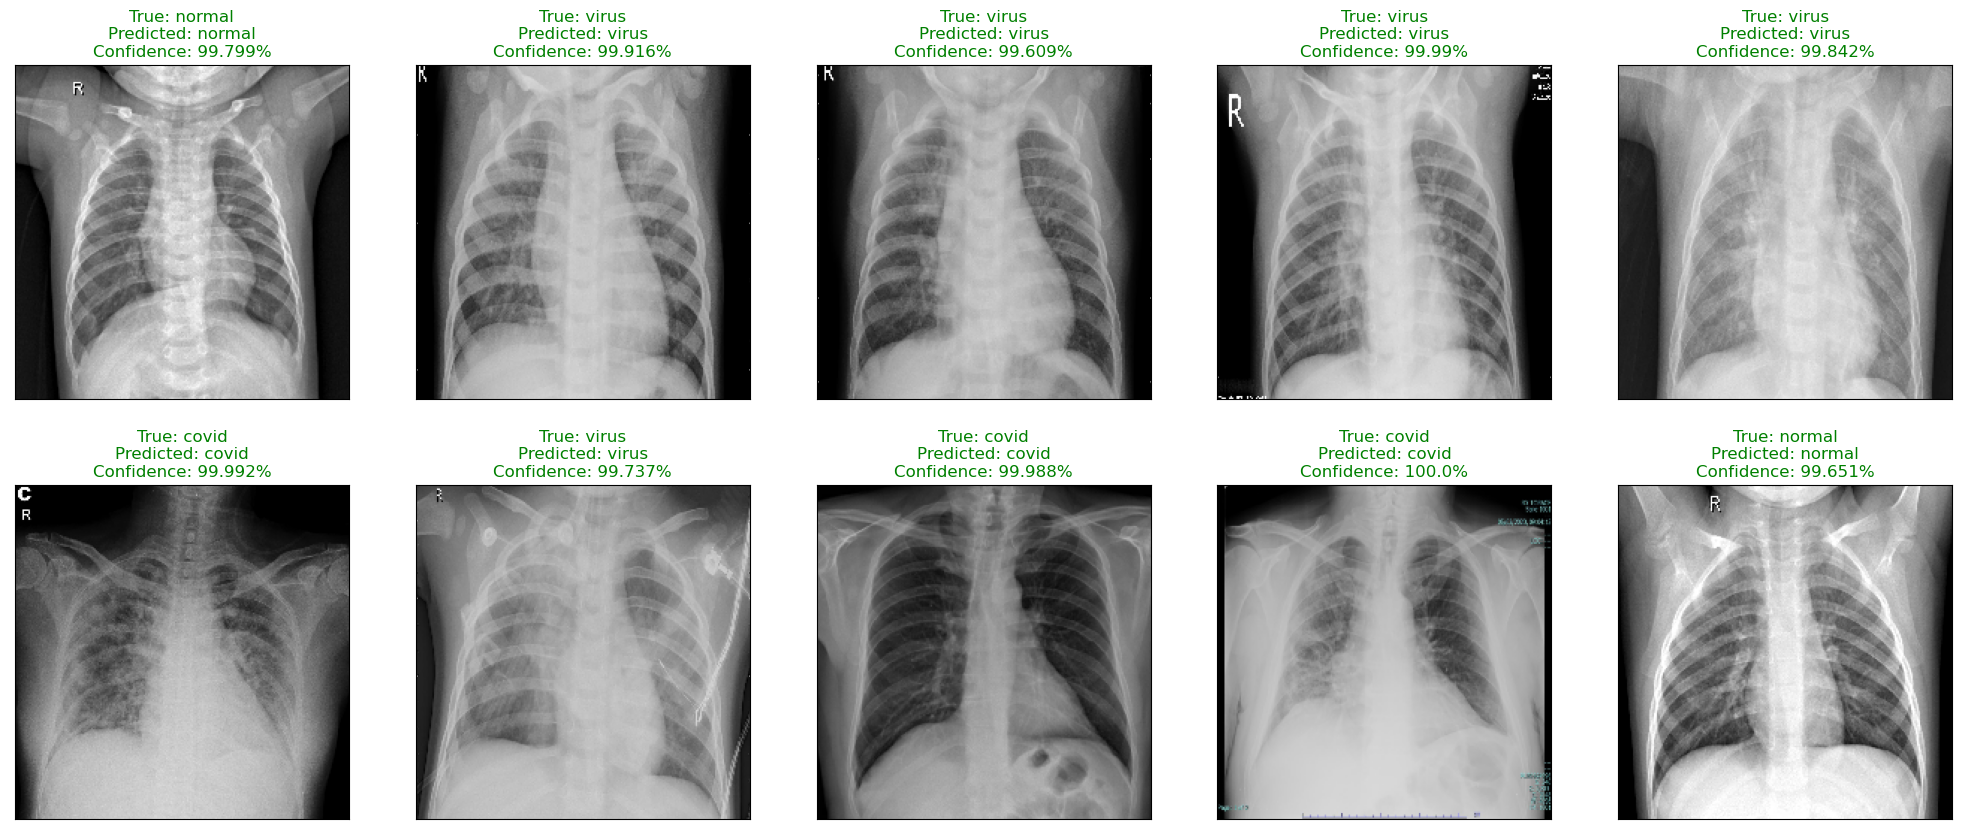

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 10 random pictures predictions from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator))

Random_Img_Index = np.random.randint(0, batch_size , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Predictions = VGG16_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0)
  
    Model_Highest_Prediction = np.argmax(Model_Predictions)  
    
    Model_Predictions_Map = { c: round(p*100,3) for (c,p) in zip (Covid_Classes, Model_Predictions.tolist()[0] ) }

    ax.imshow(Random_Img)

    Pred_Class = Covid_Classes[Model_Highest_Prediction]

    if Covid_Classes[Random_Img_Label] == Pred_Class:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {Covid_Classes[Random_Img_Label]}\nPredicted: {Pred_Class}\nConfidence: {Model_Predictions_Map[Pred_Class]}%",
          color=color)
    print(Model_Predictions_Map)
plt.show()
plt.tight_layout()

# **Comparing Models**

In [177]:
# CNN Scores
CNN_Train_Acc = CNN_history.history['accuracy'][-1] * 100
CNN_Test_Acc = CNN_Scores[1] * 100 

# DenseNet201 Scores
DenseNet201_Train_Acc = DenseNet201_history.history['accuracy'][-1] * 100
DenseNet201_Test_Acc = DenseNet201_Scores[1] * 100

# InceptionV3 Scores
InceptionV3_Train_Acc = InceptionV3_history.history['accuracy'][-1] * 100
InceptionV3_Test_Acc = InceptionV3_Scores[1] * 100

# InceptionResNetV2 Scores
InceptionResNetV2_Train_Acc = InceptionResNetV2_history.history['accuracy'][-1] * 100
InceptionResNetV2_Test_Acc = InceptionResNetV2_Scores[1] * 100

# VGG16 Scores
VGG16_Train_Acc = VGG16_history.history['accuracy'][-1] * 100
VGG16_Test_Acc = VGG16_Scores[1] * 100

In [193]:
modelsComparison = pd.DataFrame( [ ["CNN", CNN_Train_Acc, CNN_Test_Acc ],
                       ["DenseNet201", DenseNet201_Train_Acc, DenseNet201_Test_Acc ],
                        ["InceptionV3", InceptionV3_Train_Acc, InceptionV3_Test_Acc ],
                        ["InceptionResNetV2", InceptionResNetV2_Train_Acc, InceptionResNetV2_Test_Acc ],
                        ["VGG16", VGG16_Train_Acc, VGG16_Test_Acc ] ],
                       columns = ["Model", "Training Accuracy %", "Test Evaluation %"]).sort_values(by="Test Evaluation %",ascending=False)

modelsComparison.style.background_gradient(cmap='BuPu')

# **Predicting Competition Test Data**

In [179]:
print('Competation Test Images: ', len(os.listdir('/kaggle/input/shai-level-2-training-2023/test')))

Competation Test Images:  513


**Preprocssing Competition Test Data**

In [180]:
shutil.copytree('/kaggle/input/shai-level-2-training-2023/test/', '/kaggle/working/CompTest Data/test/')

'/kaggle/working/CompTest Data/test/'

In [181]:
Comptest_Path = '/kaggle/working/CompTest Data/'

test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

Comptest_generator = test_preprocessor.flow_from_directory(
        Comptest_Path,
        class_mode="categorical",
        target_size=(img_shape,img_shape),
        color_mode="rgb",
        shuffle=False,
        batch_size=batch_size,
        seed=0
    )

Found 513 images belonging to 1 classes.


**Predicting Competition Test Data**

In [183]:
Predictions_Probs = VGG16_Model.predict(Comptest_generator)

# Choosing highest probalbilty class in every prediction 
CompTest_Predictions = np.argmax(Predictions_Probs, axis=1)

9/9 [==============================] - 10s 1s/step


In [184]:
len(CompTest_Predictions)

513

**Making Submission**

In [185]:
sub = pd.read_csv('/kaggle/input/shai-level-2-training-2023/sample_submission.csv')

sub

Image  Label
0     402124007.png    NaN
1     20328626.jpeg    NaN
2     21235419.jpeg    NaN
3     188238579.png    NaN
4    266831585.jpeg    NaN
..              ...    ...
508  232629532.jpeg    NaN
509  256499192.jpeg    NaN
510  223507116.jpeg    NaN
511  178434487.jpeg    NaN
512  510641086.jpeg    NaN

[513 rows x 2 columns]

In [186]:
sub.drop(columns="Label", inplace=True)

sub

Image
0     402124007.png
1     20328626.jpeg
2     21235419.jpeg
3     188238579.png
4    266831585.jpeg
..              ...
508  232629532.jpeg
509  256499192.jpeg
510  223507116.jpeg
511  178434487.jpeg
512  510641086.jpeg

[513 rows x 1 columns]

In [187]:
Covid_Map = {0:'covid',
             1 :'normal',
             2:'virus'}

In [188]:
sub['Label'] = CompTest_Predictions

sub['Label'] = sub['Label'].map(Covid_Map)

sub

Image  Label
0     402124007.png  covid
1     20328626.jpeg  covid
2     21235419.jpeg  covid
3     188238579.png  covid
4    266831585.jpeg  covid
..              ...    ...
508  232629532.jpeg  covid
509  256499192.jpeg  covid
510  223507116.jpeg  covid
511  178434487.jpeg  covid
512  510641086.jpeg  covid

[513 rows x 2 columns]

In [189]:
Imgs_Paths = [path.split('/')[-1] for path in Comptest_generator.filepaths]

Imgs_Paths[:5]

['040263.jpeg',
 '0621724.jpeg',
 '0777738.jpeg',
 '10256151.jpeg',
 '105615245.jpeg']

In [190]:
CompTest_Predictions[:5]

array([0, 0, 0, 0, 0])

In [191]:
sub['Image'] = Imgs_Paths

sub

Image  Label
0       040263.jpeg  covid
1      0621724.jpeg  covid
2      0777738.jpeg  covid
3     10256151.jpeg  covid
4    105615245.jpeg  covid
..              ...    ...
508    93490032.jpg  covid
509   93559118.jpeg  covid
510   98633775.jpeg  covid
511   98777712.jpeg  covid
512    9947263.jpeg  covid

[513 rows x 2 columns]

In [192]:
sub.to_csv('Submission.csv', index=False)